# IMPORTING LIBRARIES

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.preprocessing import StandardScaler, MinMaxScaler, KBinsDiscretizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve, recall_score
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
import xgboost as xgb
import torch
import torch.nn as nn
import warnings
warnings.filterwarnings('ignore')

# 1. LOADING DATASET

In [2]:
df = pd.read_csv('churn_prediction.csv')

In [67]:
df[df.customer_id==6]

,customer_id,vintage,age,gender,dependents,occupation,city,customer_nw_category,branch_code,days_since_last_transaction,current_balance,previous_month_end_balance,average_monthly_balance_prevQ,average_monthly_balance_prevQ2,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance,churn
4,6,2531,42,Male,2.0,self_employed,1494.0,3,388,58.0,927.72,1401.72,1643.31,1871.12,0.33,714.61,588.62,1538.06,1157.15,1677.16,1


### Demographic information about customers
<b>customer_id</b> - Customer id<br/>
<b>vintage</b> - Vintage of the customer with the bank in number of days<br/>
<b>age</b> - Age of customer<br/>
<b>gender</b> - Gender of customer<br/>
<b>dependents</b> - Number of dependents<br/>
<b>occupation</b> - Occupation of the customer<br/> 
<b>city</b> - City of customer (anonymised)<br/>

### Customer Bank Relationship
<b>customer_nw_category</b> - Net worth of customer (3:Low 2:Medium 1:High)<br/>
<b>branch_code</b> - Branch Code for customer account<br/>
<b>days_since_last_transaction</b> - No of Days Since Last Credit in Last 1 year<br/>

### Transactional Information
<b>current_balance</b> - Balance as of today<br/>
<b>previous_month_end_balance</b> - End of Month Balance of previous month<br/>
<b>average_monthly_balance_prevQ</b> - Average monthly balances (AMB) in Previous Quarter<br/>
<b>average_monthly_balance_prevQ2</b> - Average monthly balances (AMB) in previous to previous quarter<br/>
<b>current_month_credit</b> - Total Credit Amount current month<br/>
<b>previous_month_credit</b> - Total Credit Amount previous month<br/>
<b>current_month_debit</b> - Total Debit Amount current month<br/>
<b>previous_month_debit</b> - Total Debit Amount previous month<br/>
<b>current_month_balance</b> - Average Balance of current month<br/>
<b>previous_month_balance</b> - Average Balance of previous month<br/>
<b>churn</b> - Average balance of customer falls below minimum balance in the next quarter (1/0)

# 2. EDA

In [ ]:
df.dtypes

In [5]:
time_based_cols = [
    "vintage",
    "days_since_last_transaction",
    "age"
]

cont_cols = [
    "current_balance",
    "previous_month_end_balance",
    "average_monthly_balance_prevQ",
    "average_monthly_balance_prevQ2",
    "current_month_credit",
    "previous_month_credit",
    "current_month_debit",
    "previous_month_debit",
    "current_month_balance",
    "previous_month_balance"
]

cat_cols = [
    "branch_code",
    "customer_nw_category",
    "city",
    "occupation",
    "gender",
    "dependents"
]

## 2.0 MISSING VALUES

In [68]:
print("COLUMNS".ljust(30) + "COUNT".ljust(10) + "%")
for i in df.columns:
    print(i.ljust(30) + str(df[i].isna().sum()).ljust(10) + str(round(df[i].isna().sum() / len(df), 2) * 100))

COLUMNS                       COUNT     %
customer_id                   0         0.0
vintage                       0         0.0
age                           0         0.0
gender                        525       2.0
dependents                    2463      9.0
occupation                    80        0.0
city                          803       3.0
customer_nw_category          0         0.0
branch_code                   0         0.0
days_since_last_transaction   3223      11.0
current_balance               0         0.0
previous_month_end_balance    0         0.0
average_monthly_balance_prevQ 0         0.0
average_monthly_balance_prevQ20         0.0
current_month_credit          0         0.0
previous_month_credit         0         0.0
current_month_debit           0         0.0
previous_month_debit          0         0.0
current_month_balance         0         0.0
previous_month_balance        0         0.0
churn                         0         0.0


<AxesSubplot:>

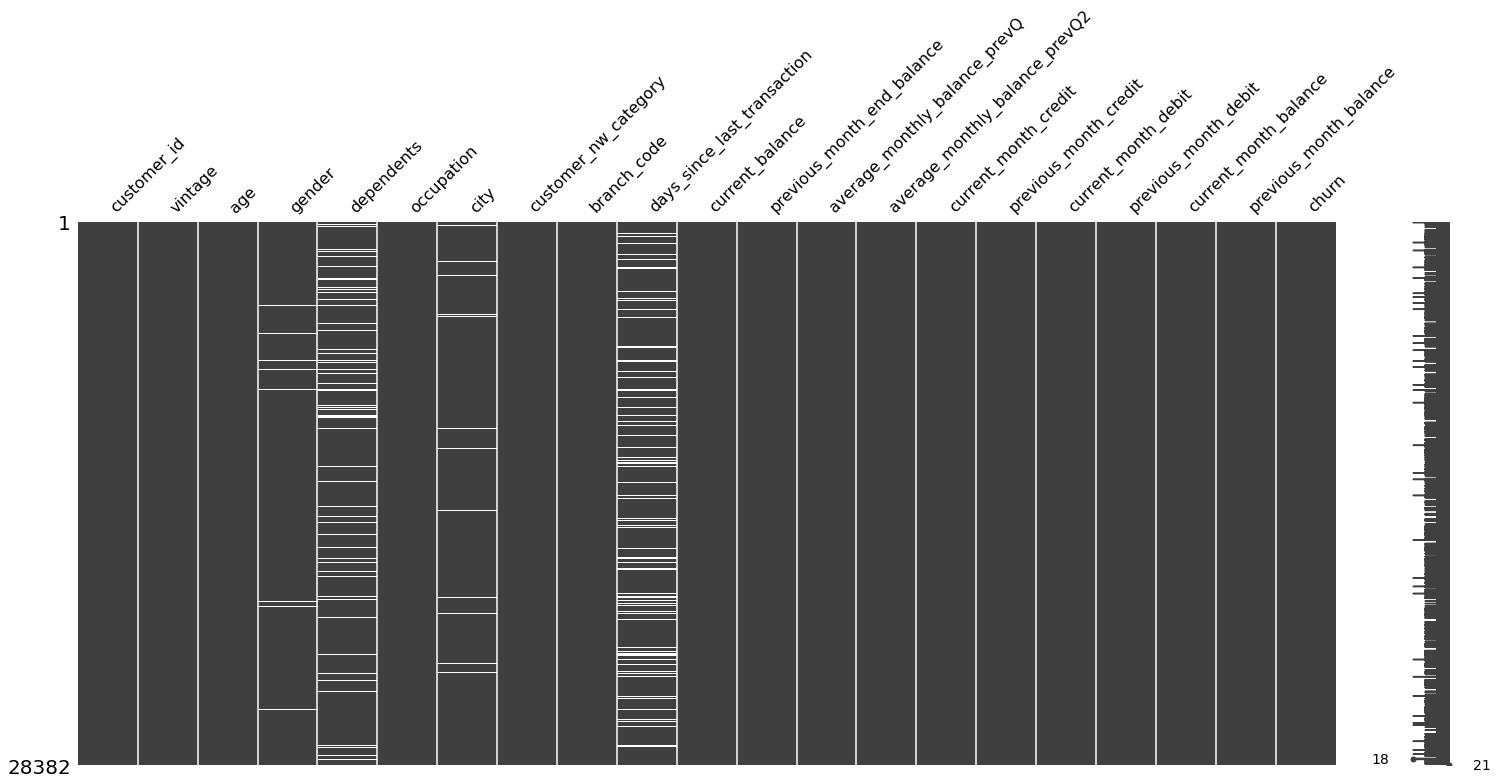

In [69]:
msno.matrix(df)

## 2.1 UNIVARIATE

#### UNIVARIATE CONTINOUS

In [70]:
def uni_cont(df):
    plt.figure(figsize=(20, 5))
    mini = df.min()[0]
    maxi = df.max()[0]
    mean = df.mean()[0]
    median = df.median()[0]
    std = df.std()[0]
    skew = df.skew()[0]
    kurtosis = df.kurtosis()[0]
    sns.kdeplot(df.squeeze())
    sns.scatterplot([mean], [0], color="red", label="mean", s=200)
    sns.scatterplot([median], [0], color="blue", label="median", s=200)
    sns.scatterplot([mini, maxi], [0, 0], color="green", label="min/max", s=200)
    plt.ylabel("density")
    plt.xlabel(df.columns[0])
    plt.title("{} | min = {} | max = {} | std = {} | kurtosis = {} | skew = {} | mean = {} | median = {}".format(df.columns[0], round(mini,2), round(maxi,2), round(std,3), round(kurtosis,3), round(skew,3), round(mean,3), round(median,3)))

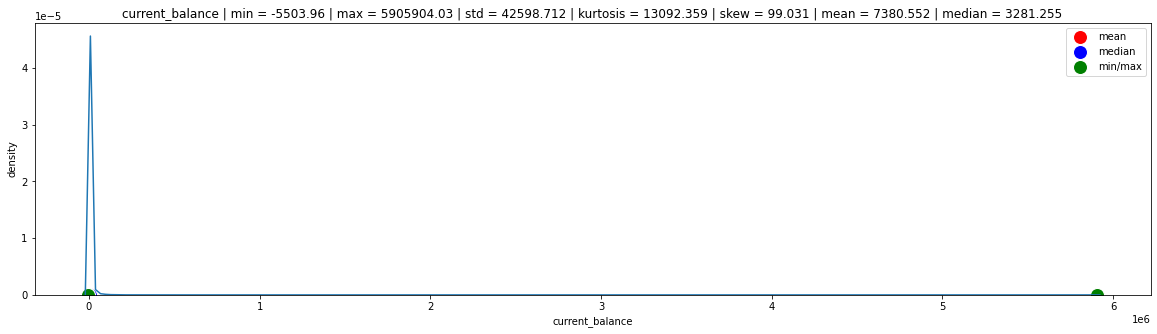

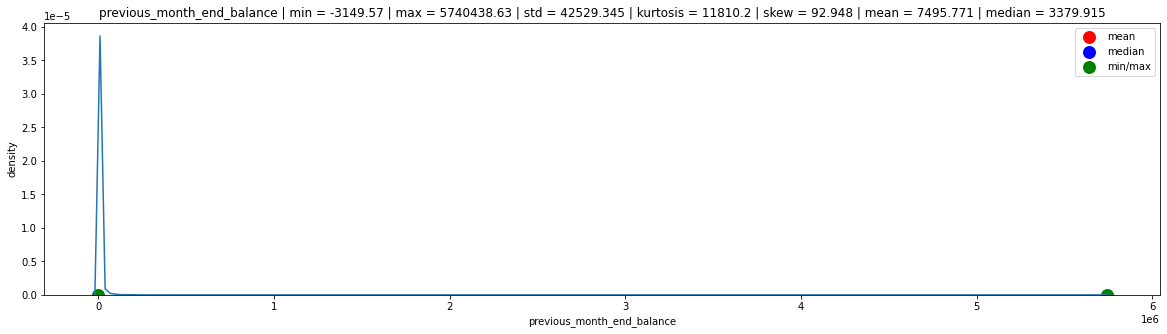

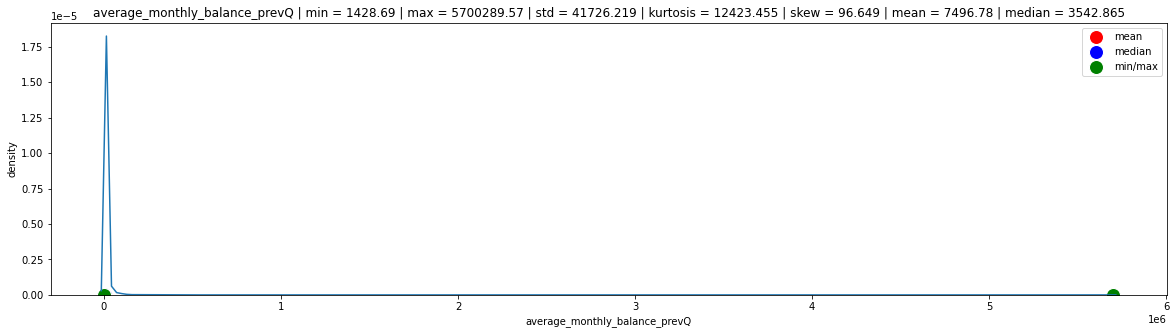

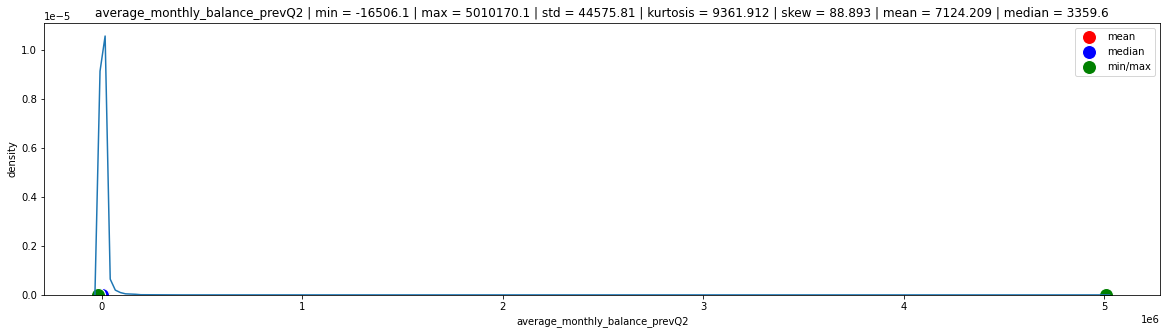

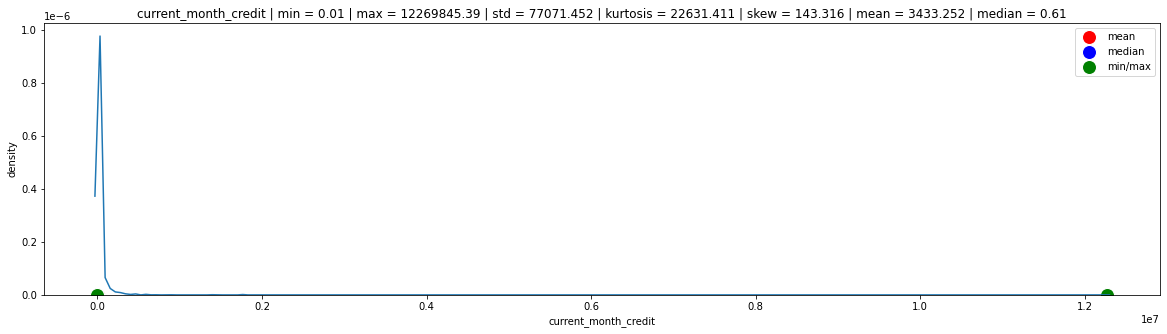

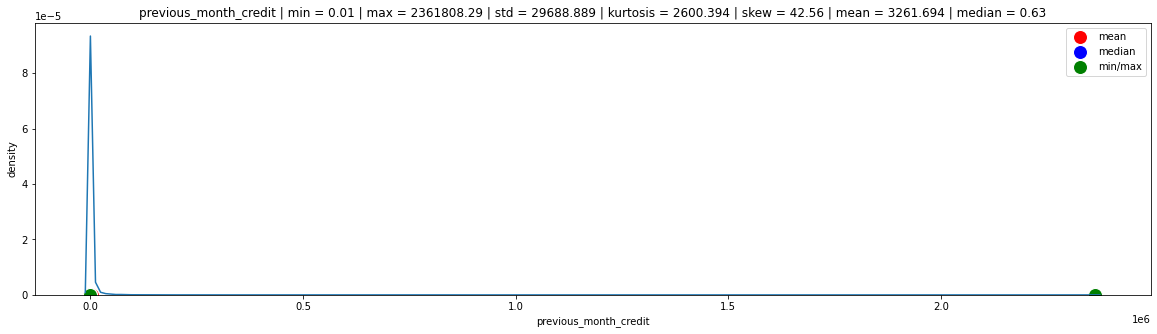

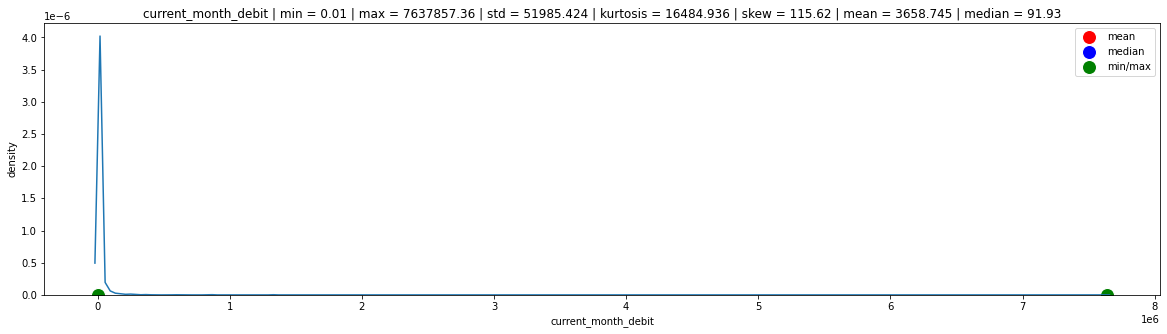

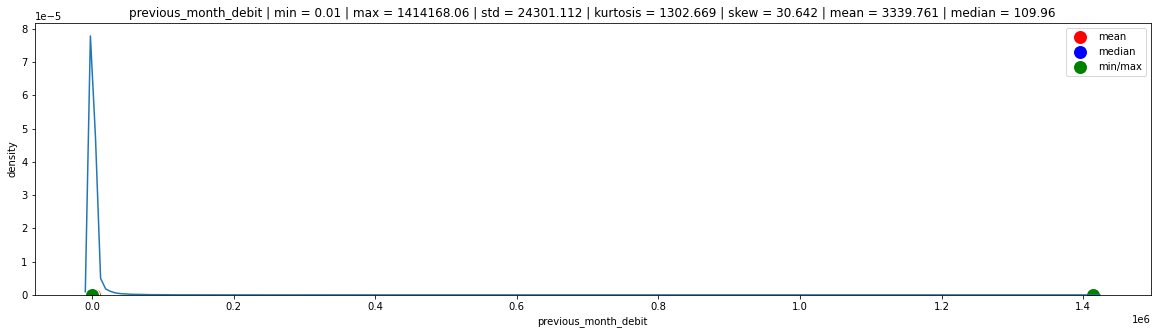

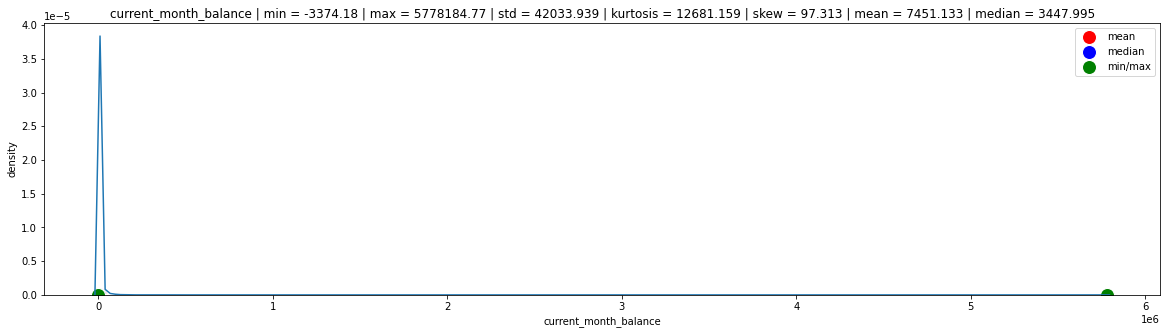

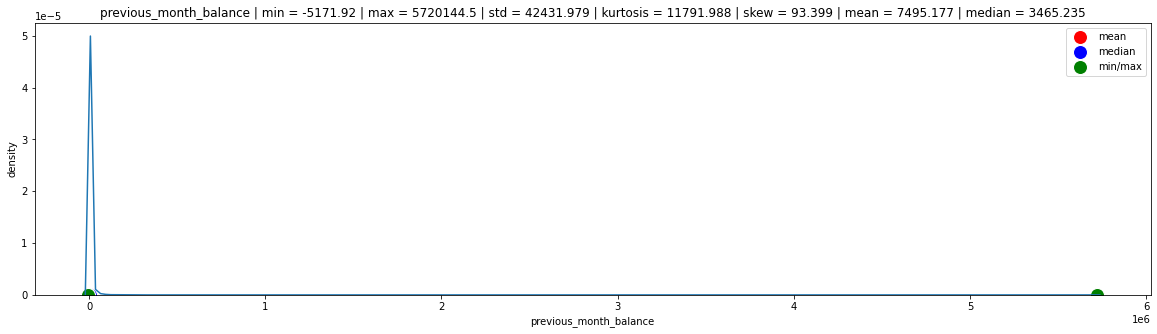

In [71]:
for i in cont_cols:
    uni_cont(df[[i]])

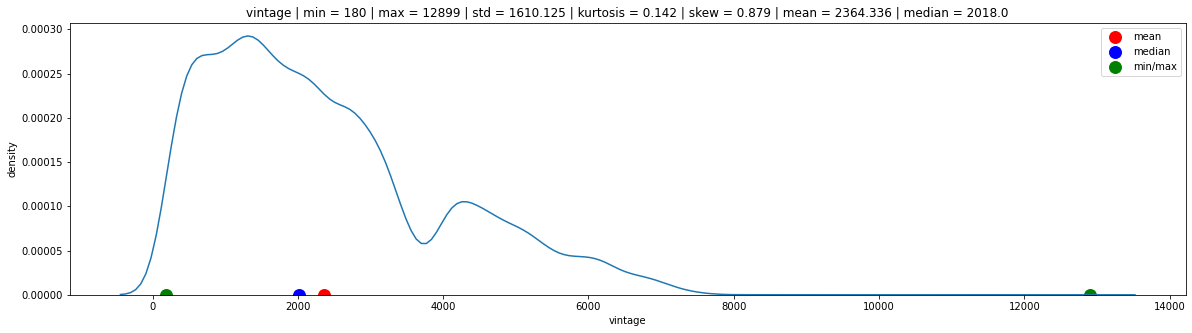

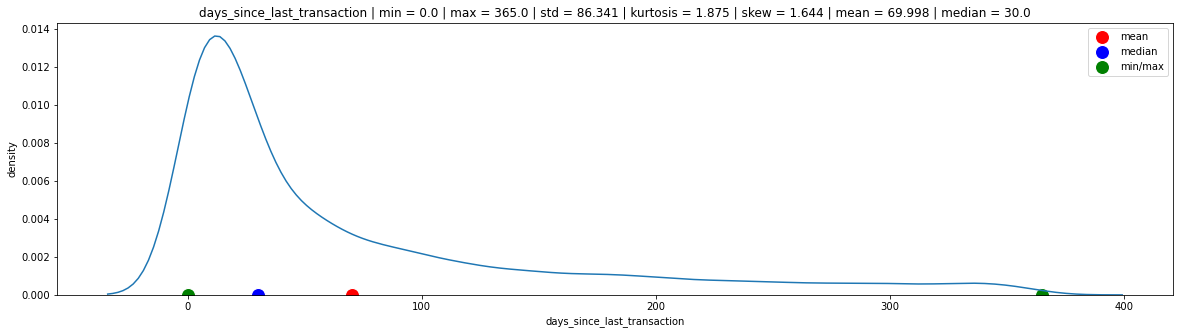

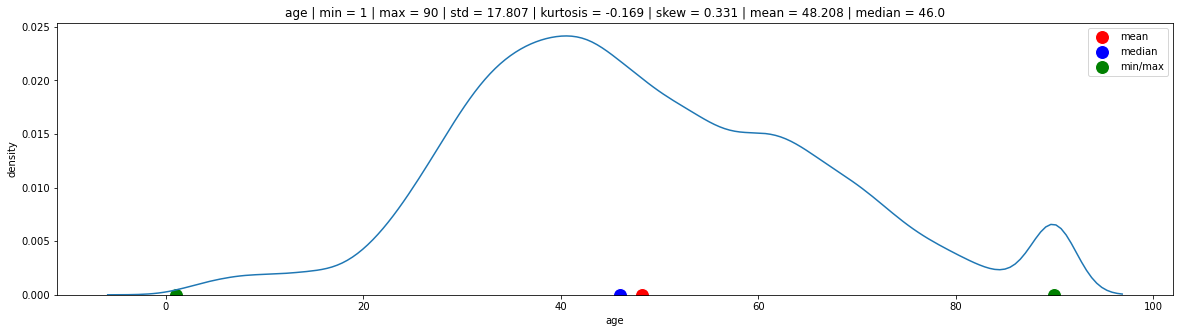

In [72]:
for i in time_based_cols:
    uni_cont(df[[i]])

#### OUTLIER

In [73]:
outlier_df = pd.DataFrame()
def outlier(df):
    global outlier_df
    plt.figure(figsize =(5, 5))
    IQR = df.quantile(0.75) - df.quantile(0.25)
    MAX = df.quantile(0.75) + (1.5 * IQR)
    MIN = df.quantile(0.25) - (1.5 * IQR)
    outlier_df = pd.concat([outlier_df, df[(df[[i]] > MAX) | (df[[i]] < MIN)].dropna()], axis = 0)
    plt.title(i + "  |  outliers = " + str(df[(df[[i]] > MAX) | (df[[i]] < MIN)].count()[0]) + " " + str(round(df[(df[[i]] > MAX) | (df[[i]] < MIN)].count()[0] / len(df) * 100, 2)) + "%")
    plt.boxplot(df[i])

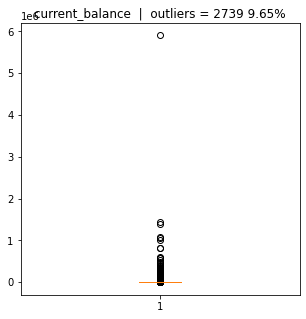

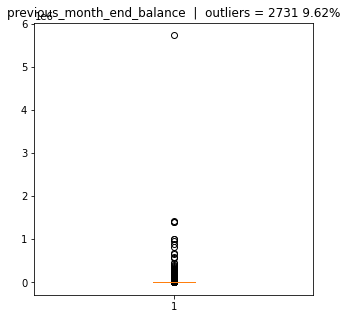

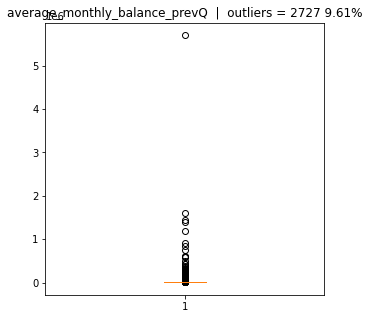

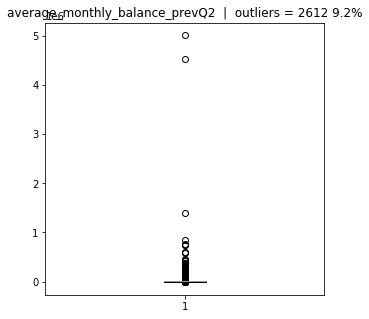

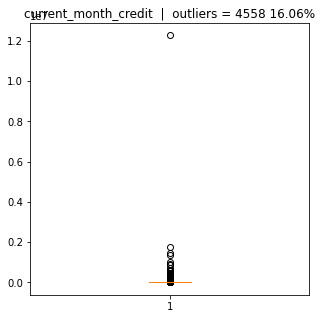

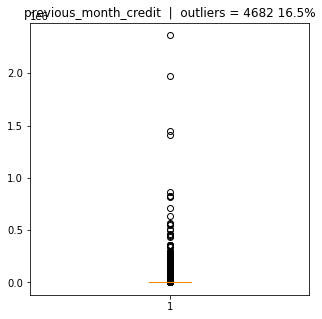

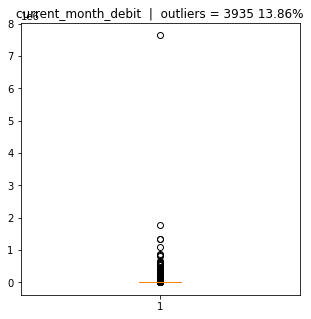

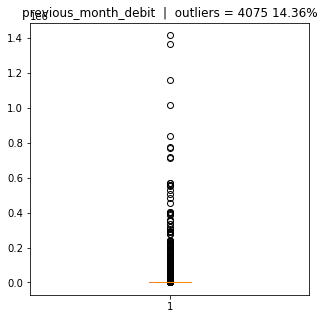

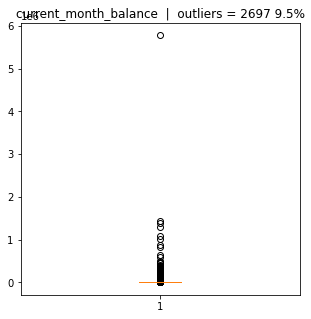

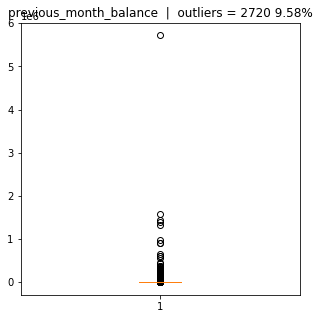

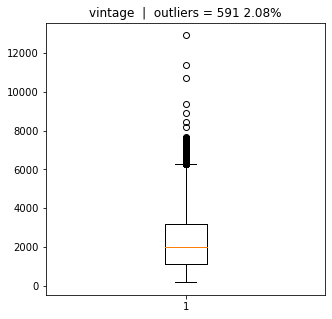

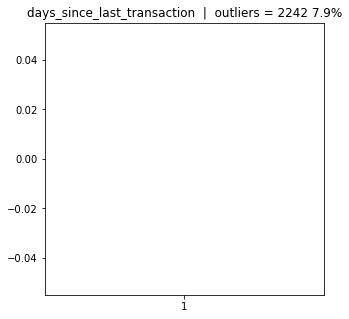

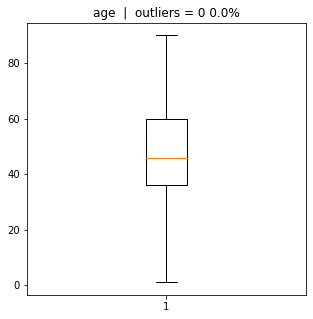

In [74]:
for i in cont_cols + time_based_cols:
    outlier(df[[i]])

#### OUTLIER DATAFRAME

In [75]:
outlier_df = pd.DataFrame()
for i in cont_cols + time_based_cols:
    IQR = df[i].quantile(0.75) - df[i].quantile(0.25)
    MAX = df[i].quantile(0.75) + (1.5 * IQR)
    MIN = df[i].quantile(0.25) - (1.5 * IQR)
    outlier_df = pd.concat([outlier_df, df[(df[i] > MAX) | (df[i] < MIN)]], axis = 0)
    outlier_df = outlier_df.drop_duplicates()

In [76]:
outlier_df

,customer_id,vintage,age,gender,dependents,occupation,city,customer_nw_category,branch_code,days_since_last_transaction,current_balance,previous_month_end_balance,average_monthly_balance_prevQ,average_monthly_balance_prevQ2,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance,churn
5,7,263,42,Female,0.0,self_employed,1096.0,2,1666,60.0,15202.20,16059.34,15211.29,13798.82,0.36,0.36,857.50,286.07,15719.44,15349.75,0
25,28,606,76,Male,NaN,self_employed,1533.0,3,881,NaN,14289.26,14289.26,14289.26,14443.43,0.64,0.64,0.64,0.64,14289.26,14289.26,0
26,29,2620,36,Male,2.0,self_employed,1563.0,1,58,20.0,20273.43,23106.03,26221.15,5594.83,7.83,722.68,853.09,1557.17,21741.48,25504.19,0
53,57,2292,34,Male,0.0,self_employed,146.0,3,353,3.0,21252.86,20848.89,21926.19,18861.56,782.48,0.47,344.44,1912.35,20721.47,21741.64,0
67,71,3952,79,Female,0.0,self_employed,1020.0,2,442,25.0,15942.78,16707.64,16215.43,21975.14,604.96,487.74,1286.36,1244.91,16115.08,16619.75,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28229,30140,859,30,Male,NaN,salaried,572.0,2,1627,312.0,4184.95,4181.15,4181.51,5681.81,0.14,0.14,0.14,0.14,4184.95,4181.15,0
28276,30190,2859,40,Female,0.0,self_employed,531.0,2,588,352.0,2462.71,2462.71,2462.71,2670.80,0.66,0.66,0.66,0.66,2462.71,2462.71,0
28318,30234,4277,37,Male,0.0,self_employed,NaN,2,1491,315.0,1389.27,1434.98,1471.50,1530.22,0.03,0.03,0.03,0.03,1430.25,1481.71,0
28360,30280,4801,41,Female,0.0,self_employed,834.0,3,174,287.0,4825.45,3467.85,2541.91,1171.77,0.06,0.06,2901.31,71.49,4717.69,1751.67,0


#### UNIVARIATE CATEGORICAL

In [77]:
def uni_cat(df):
    plt.figure(figsize=(20, 5))
    summary = pd.DataFrame(df.groupby(df.columns[1])[df.columns[0]].count())
    summary.reset_index(inplace = True)
    b = sns.barplot(list(summary.values[:,0]), list(summary.values[:,1]))
    if len(summary) < 100:
        for index, row in summary.iterrows():
            b.text(row.name, row.customer_id, str(row.customer_id) + " : " + str(round((row.customer_id*100)/df.shape[0], 2)) + "%", color='black', ha="center")
    plt.title(df.columns[1])
    plt.xlabel(df.columns[1])
    plt.ylabel('count')
    plt.show()

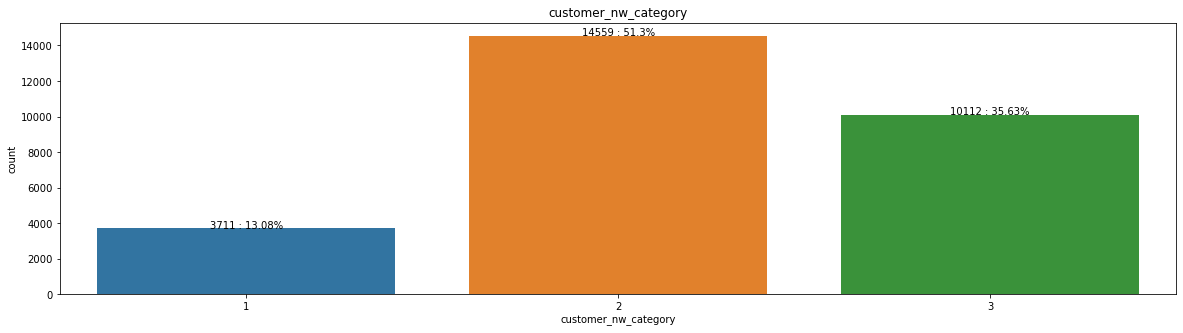

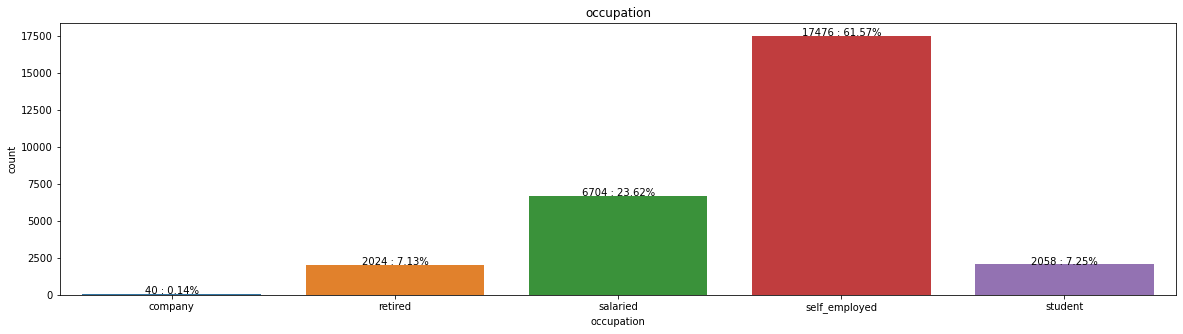

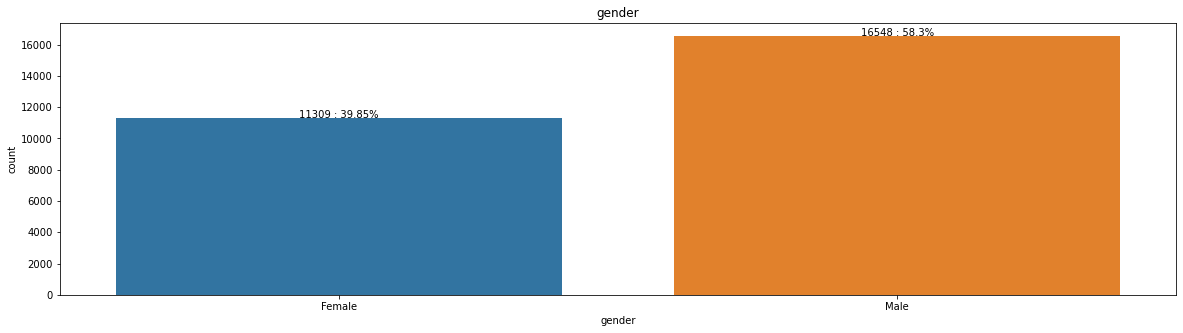

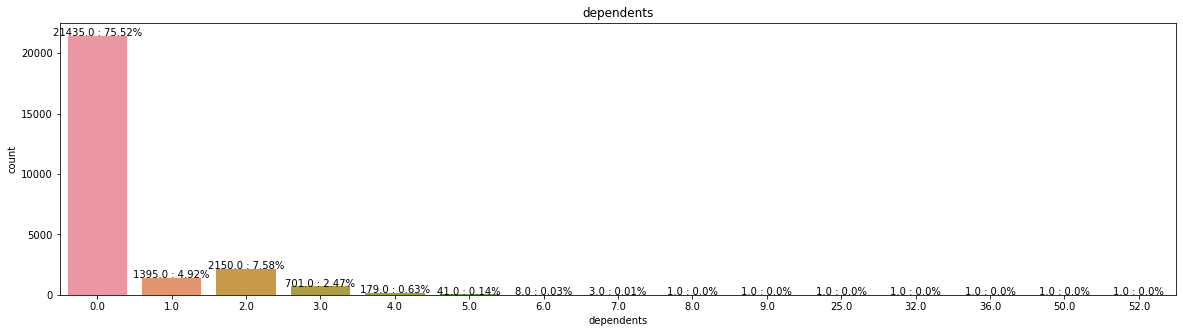

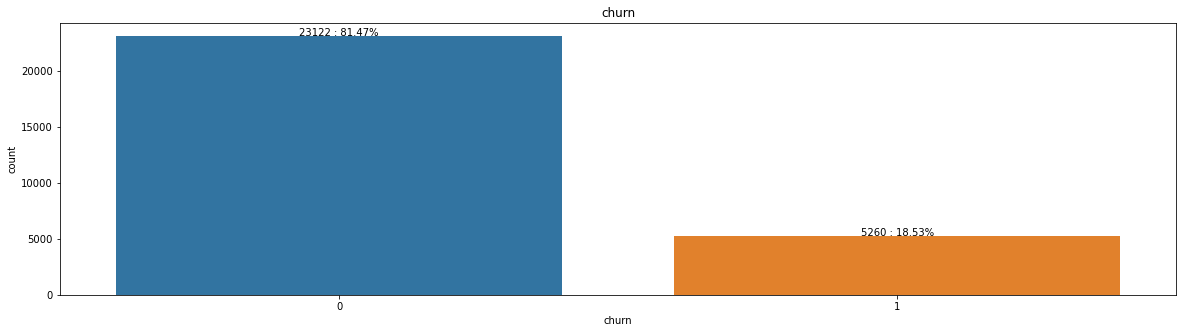

In [78]:
for i in ["customer_nw_category", "occupation", "gender", "dependents", "churn"]:
    uni_cat(df[['customer_id', i]])

In [79]:
df.branch_code.value_counts()

19      145
6       142
60      128
16      111
8       109
       ... 
4074      1
3205      1
3189      1
3109      1
2049      1
Name: branch_code, Length: 3185, dtype: int64

In [80]:
df.branch_code.nunique()

3185

In [81]:
df.city.value_counts()

1020.0    3479
1096.0    2016
409.0     1334
146.0     1291
834.0     1138
          ... 
1601.0       1
1093.0       1
1313.0       1
1391.0       1
1174.0       1
Name: city, Length: 1604, dtype: int64

In [82]:
df.city.nunique()

1604

## 2.2 BIVARIATE

#### CONTINOUS - CONTINOUS

In [ ]:
sns.pairplot(df[cont_cols + time_based_cols])

#### CONTINOUS - CATEGORICAL

In [83]:
def cont_cat(df):
    plt.figure(figsize=(20, 5))
    summary = pd.DataFrame(df.groupby(df.columns[1])[df.columns[0]].median())
    summary.reset_index(inplace = True)
    b = sns.barplot(list(summary.values[:,0]), list(summary.values[:,1]))
    for index, row in summary.iterrows():
        b.text(row.name, row[i], round(row[i], 2), color='black', ha="center")
    plt.title(df.columns[0])
    plt.xlabel(df.columns[1])
    plt.ylabel(df.columns[0])
    plt.show()

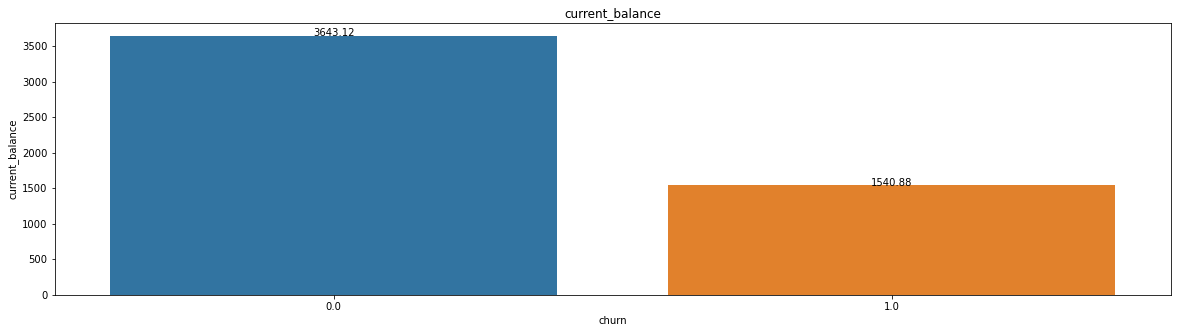

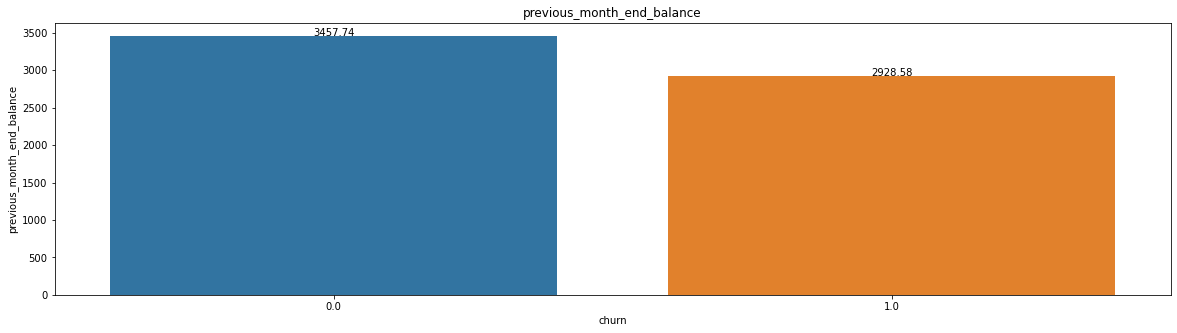

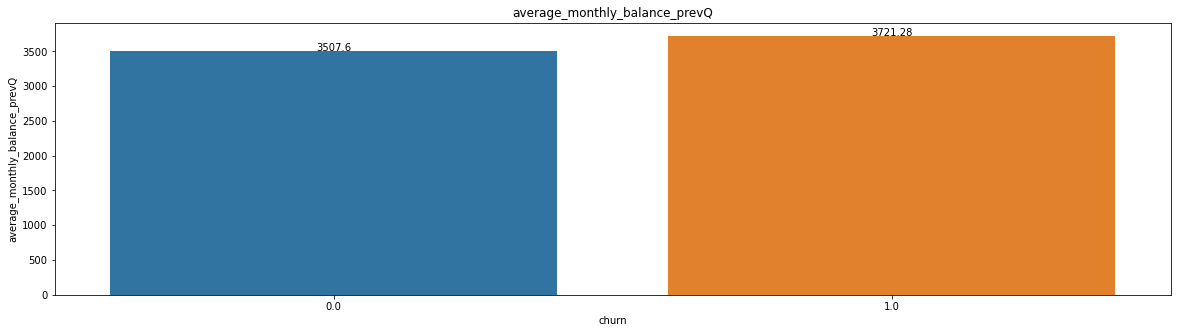

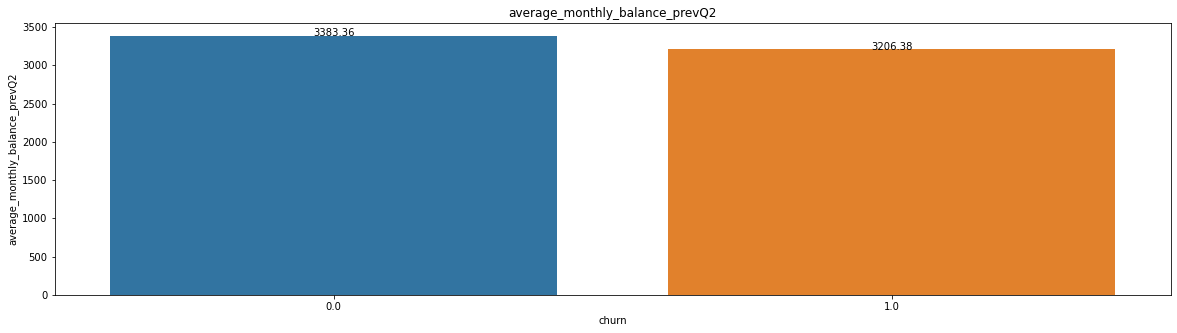

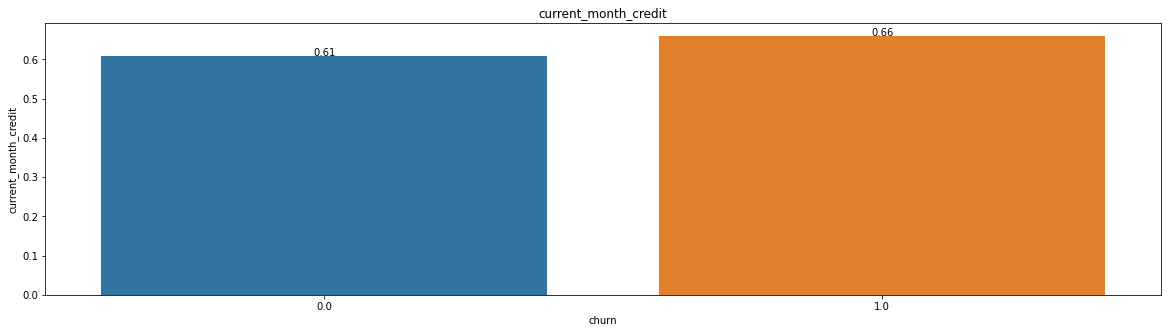

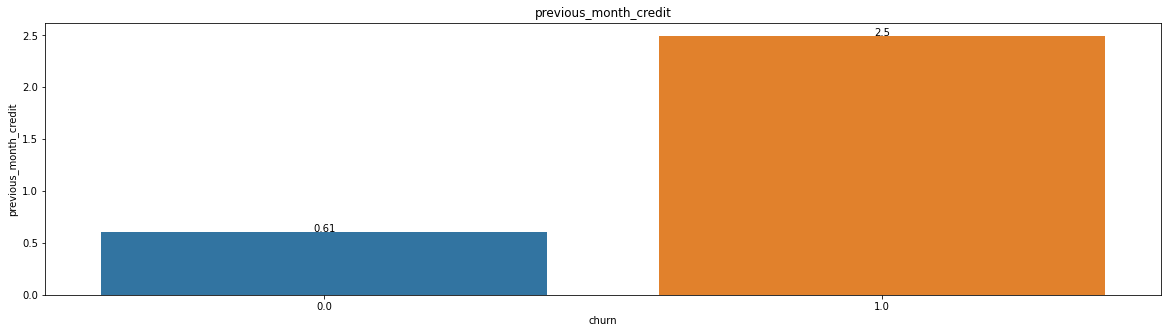

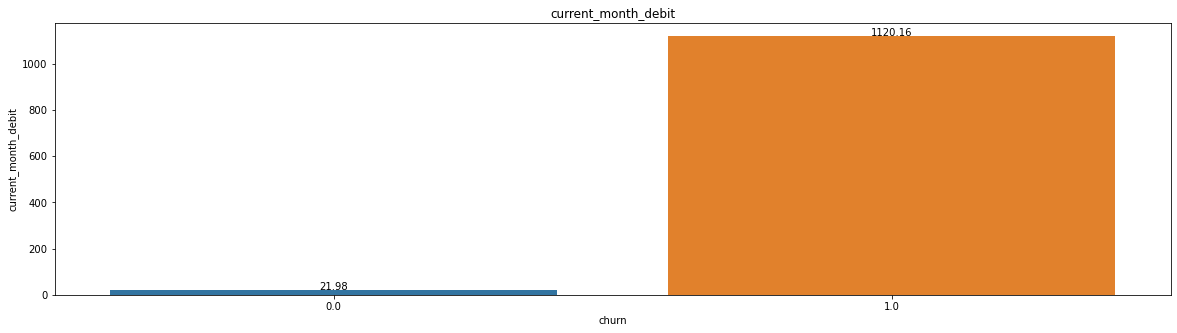

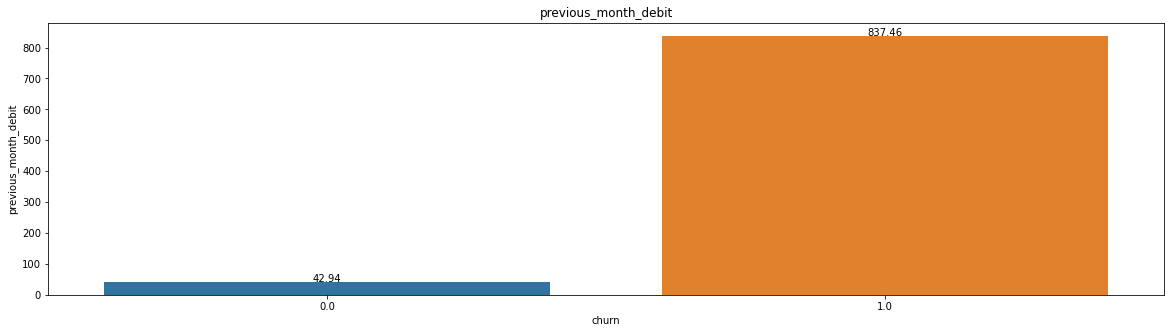

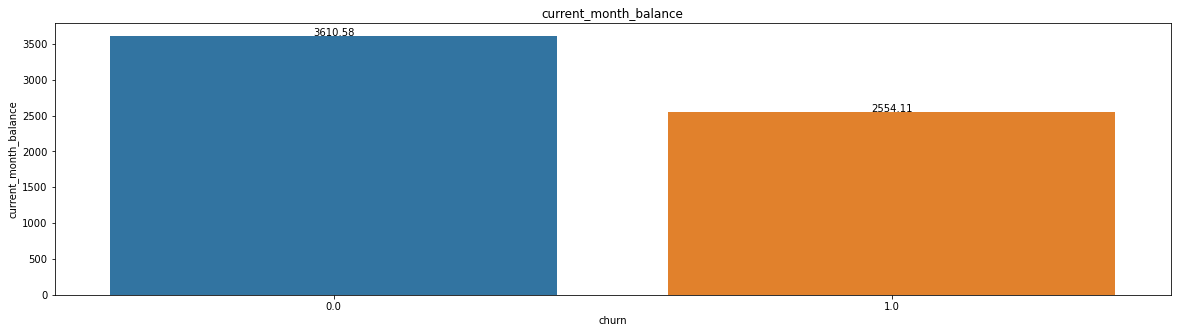

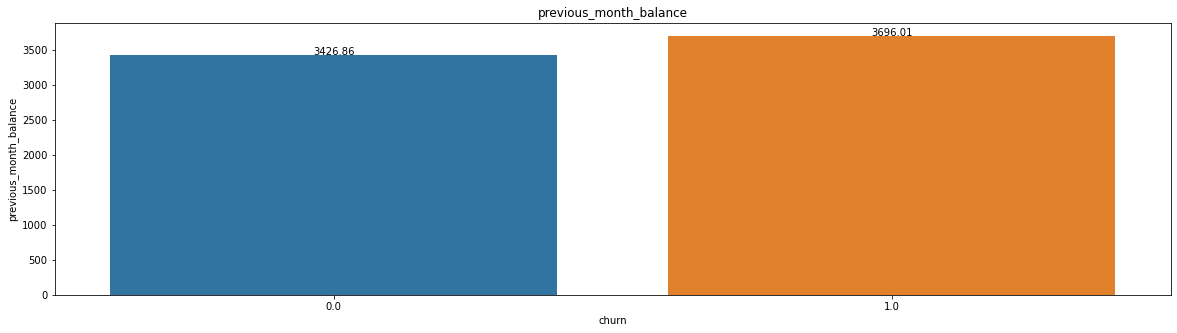

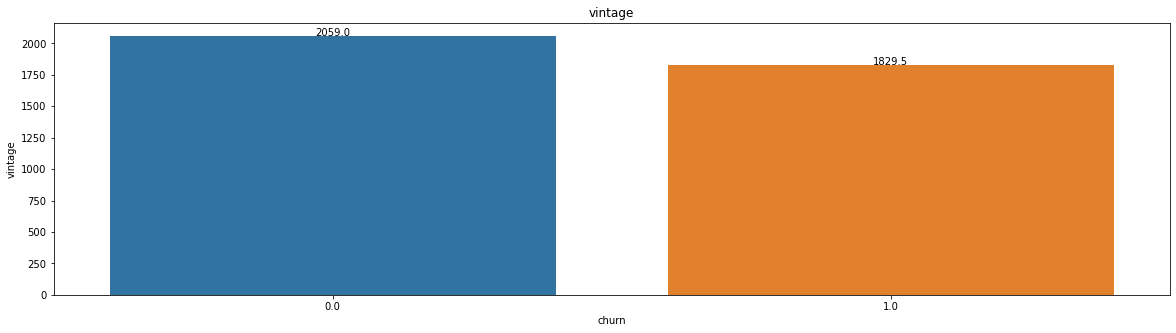

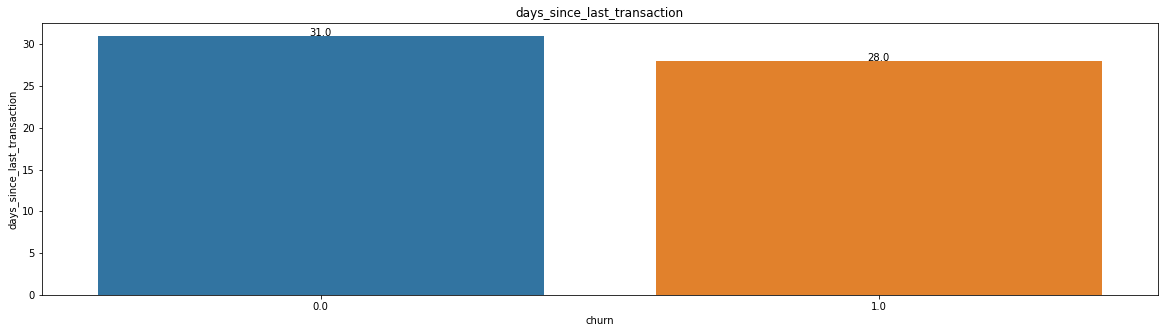

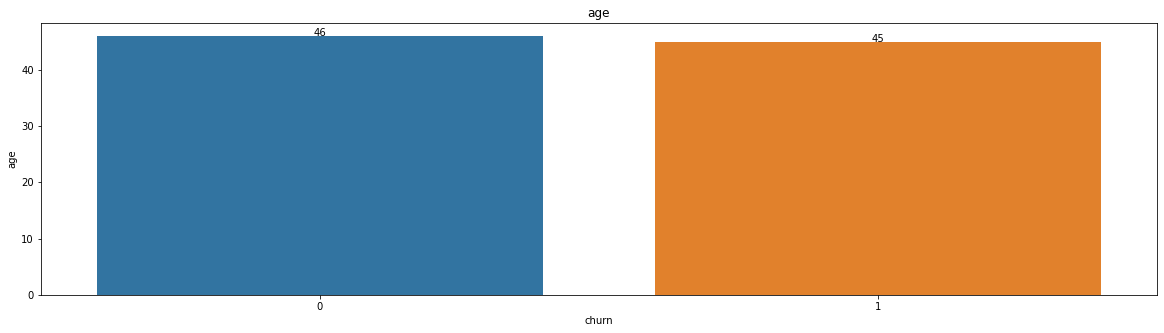

In [84]:
for i in cont_cols + time_based_cols:
    cont_cat(df[[i, "churn"]])

In [85]:
def cat_cat(df):
    s = pd.DataFrame(df.groupby([df.columns[0], df.columns[1]]).count()).iloc[:,:1]
    s.reset_index(inplace = True)
    s.columns = [df.columns[0], df.columns[1], "Count"]
    sns.catplot(x=df.columns[0], y='Count', hue=df.columns[1], kind="bar", data=s, height=4, aspect=4)

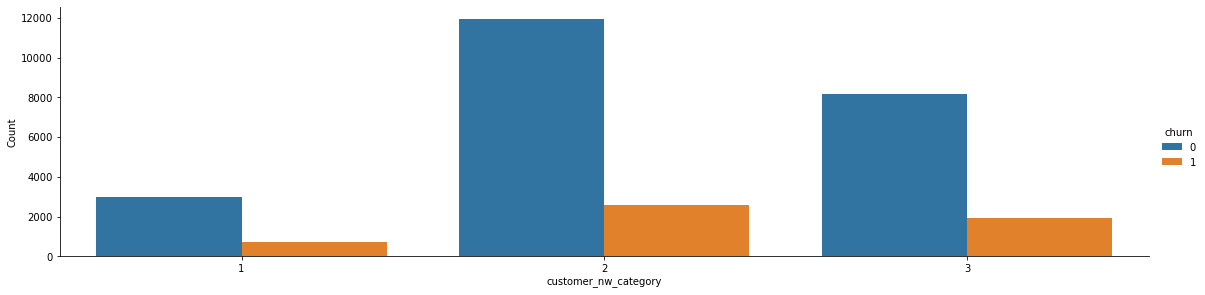

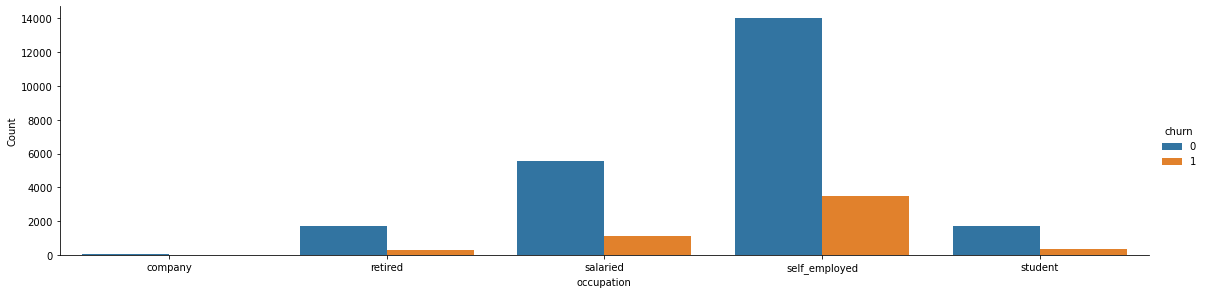

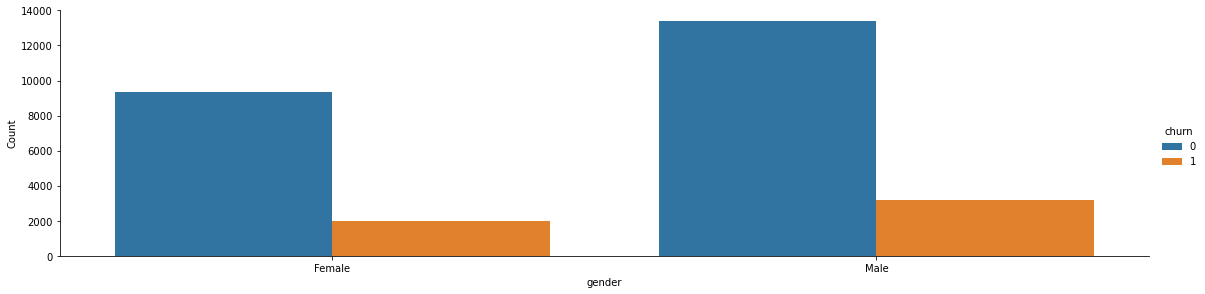

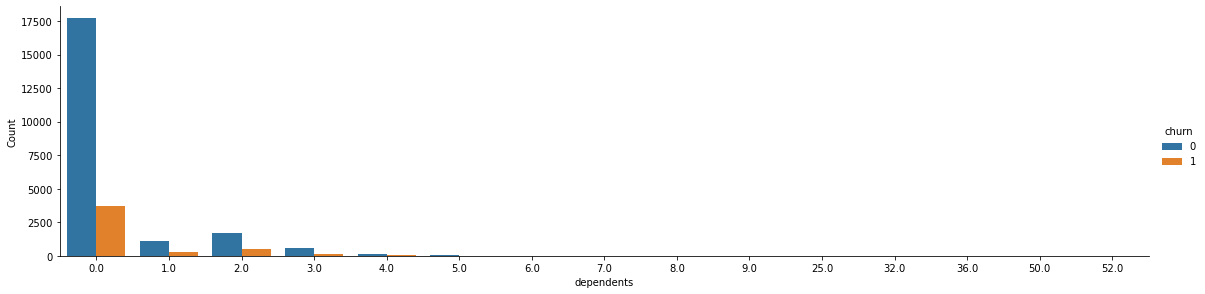

In [86]:
for i in ["customer_nw_category", "occupation", "gender", "dependents"]:
    cat_cat(df[[i, "churn", "customer_id"]])

## 2.3 OUTLIER ANALYSIS

#### CONTINOUS

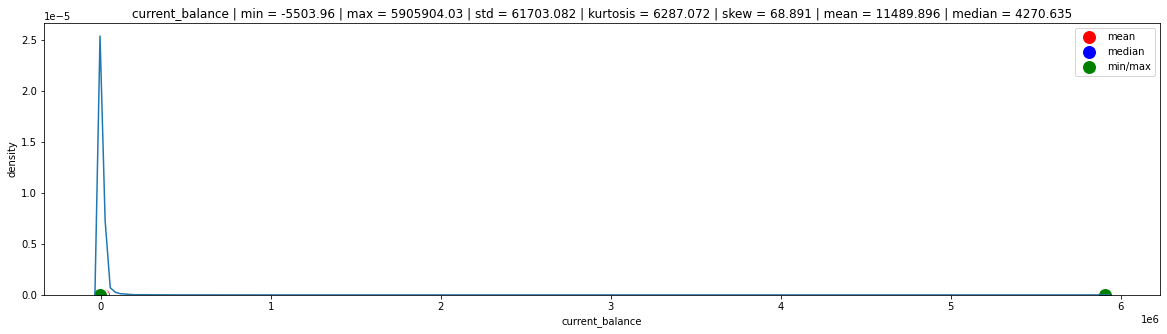

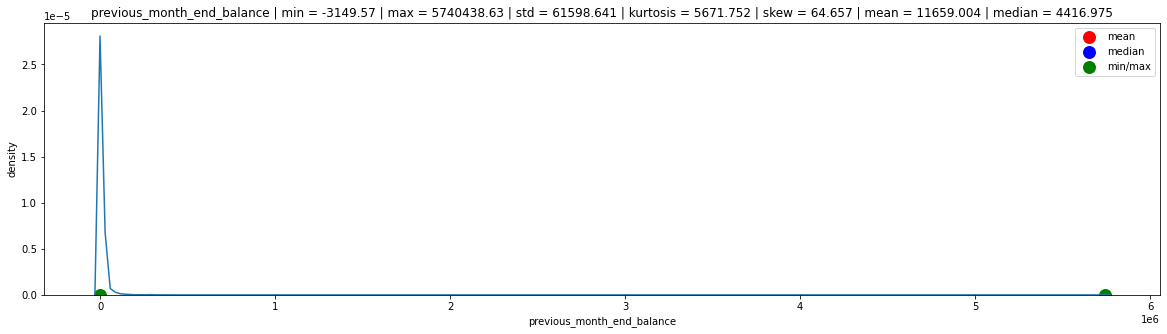

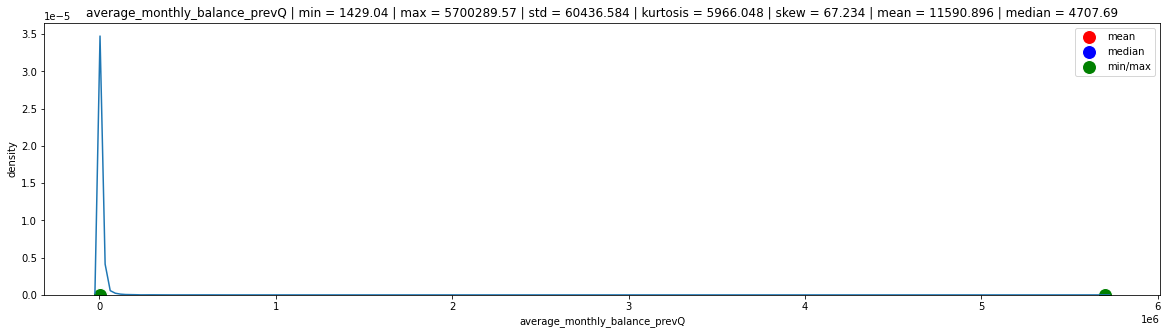

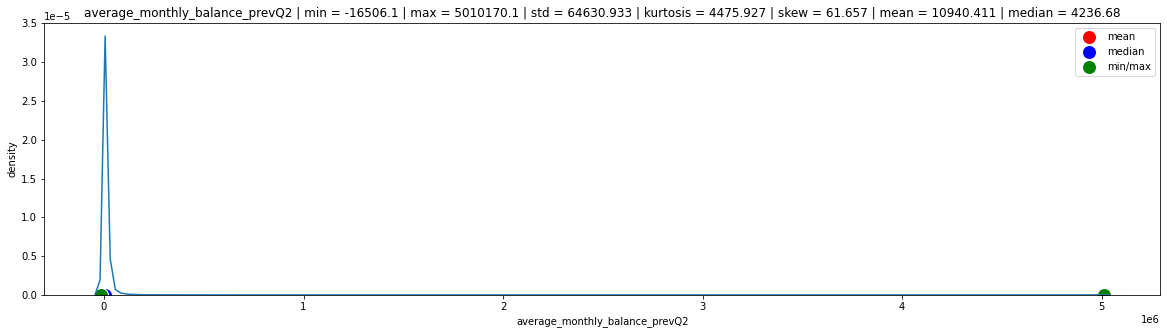

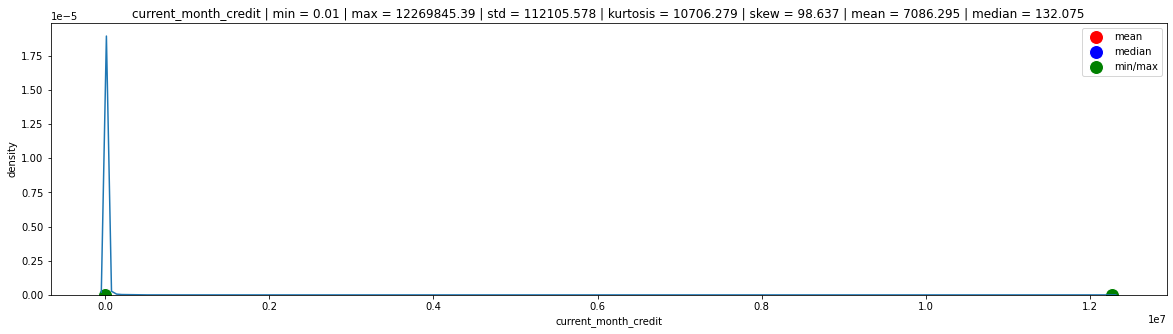

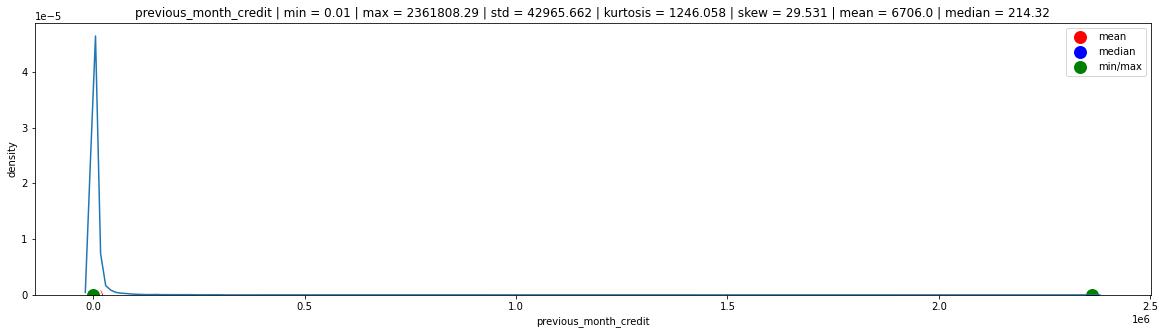

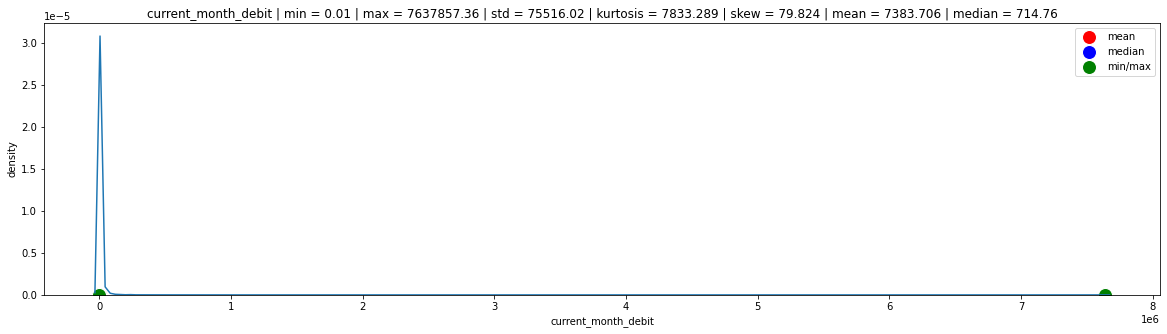

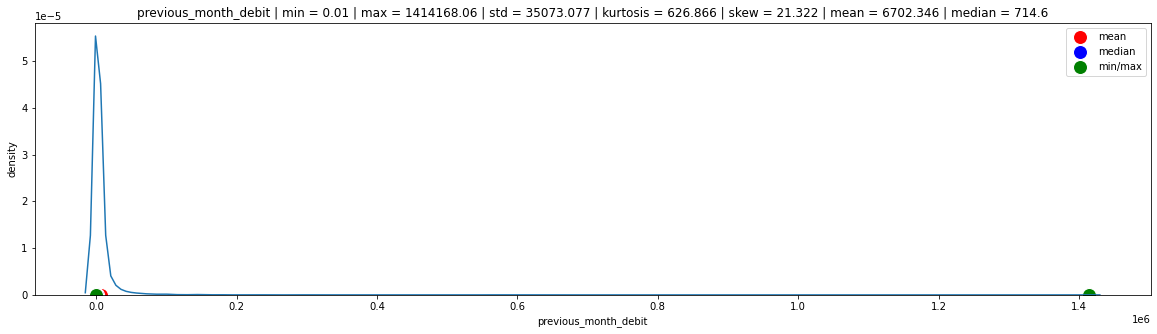

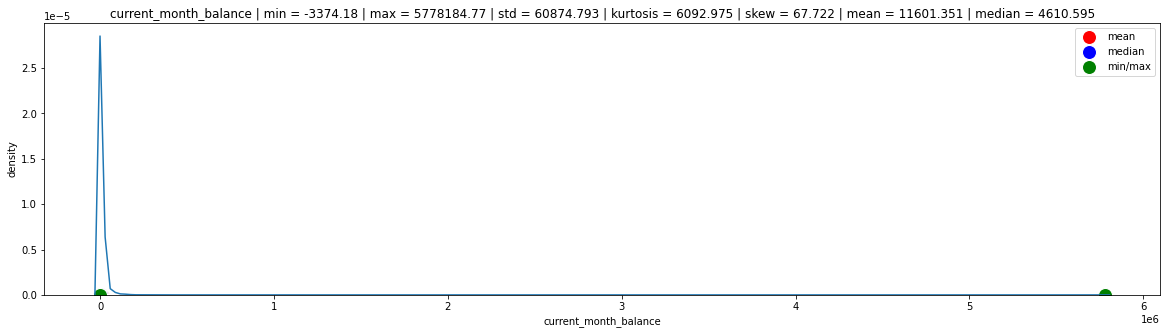

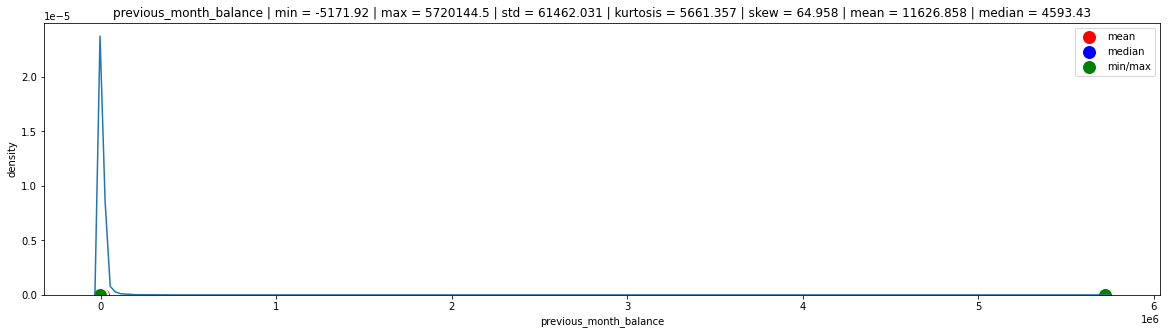

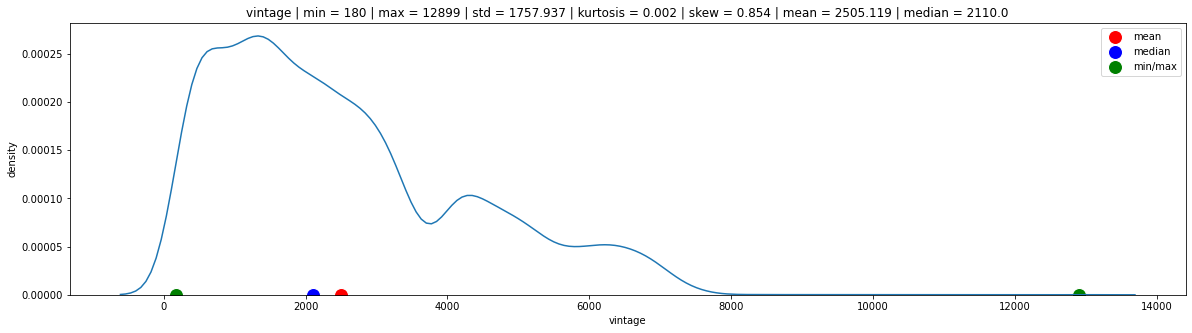

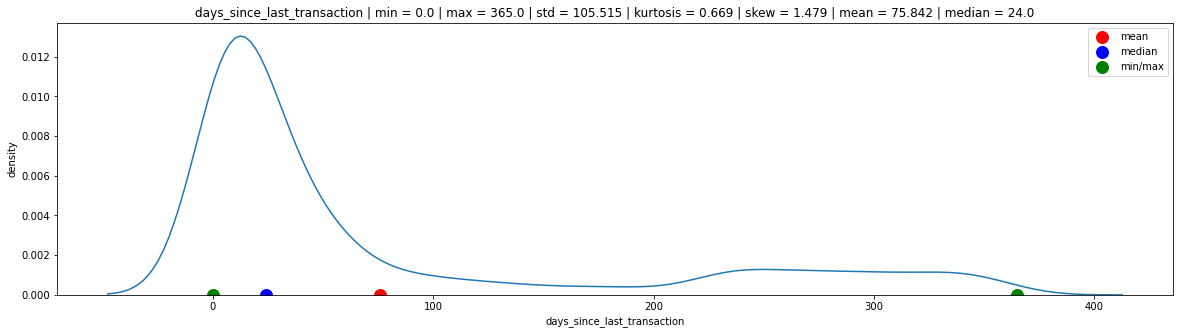

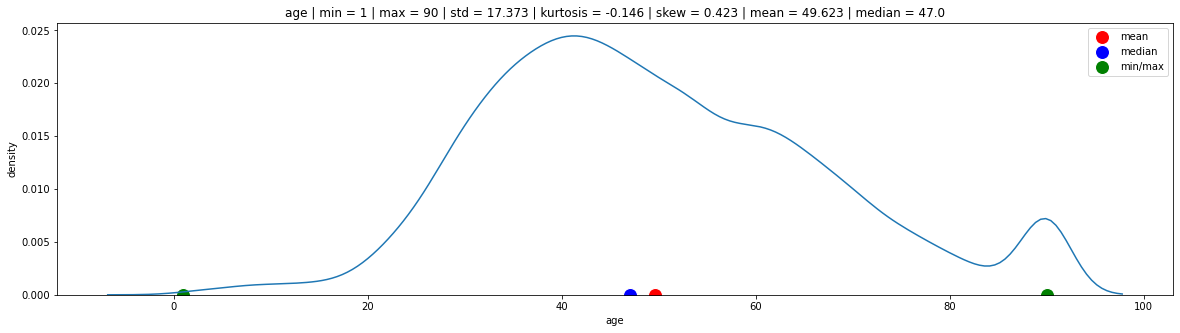

In [87]:
for i in cont_cols + time_based_cols:
    uni_cont(outlier_df[[i]])

#### CATEGORICAL

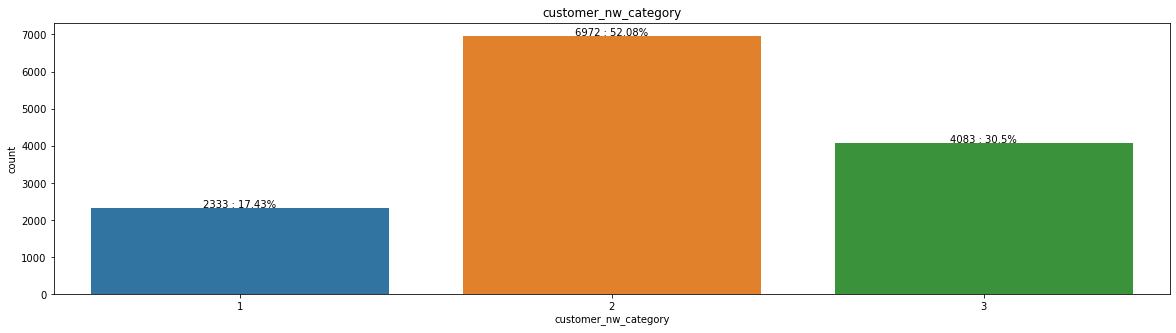

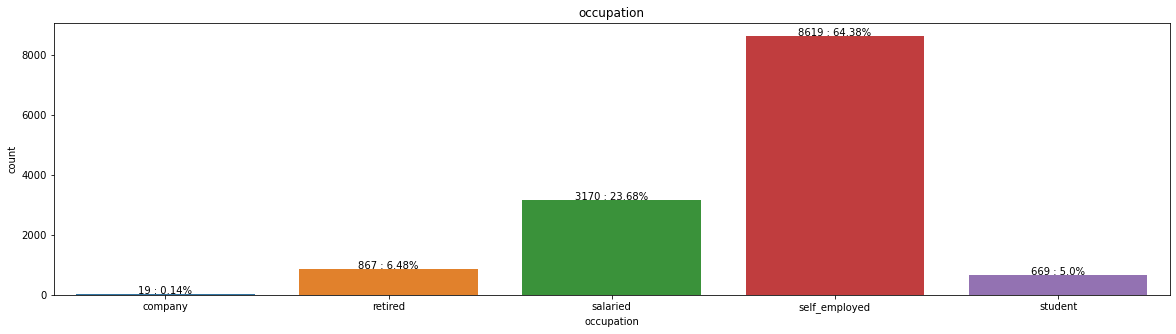

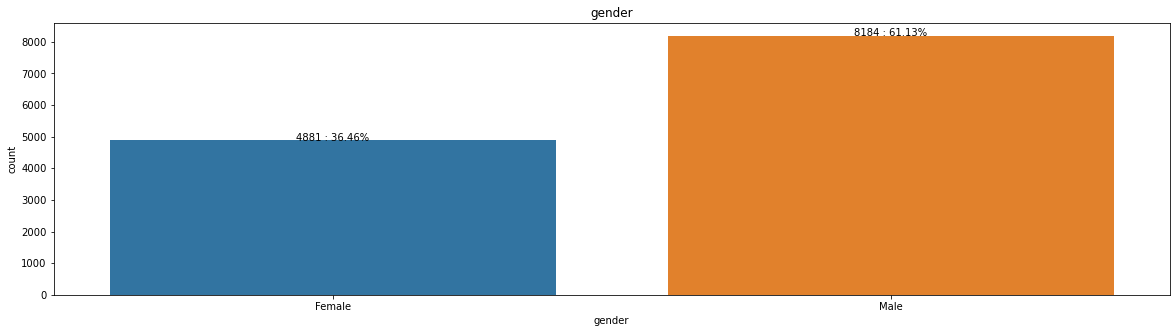

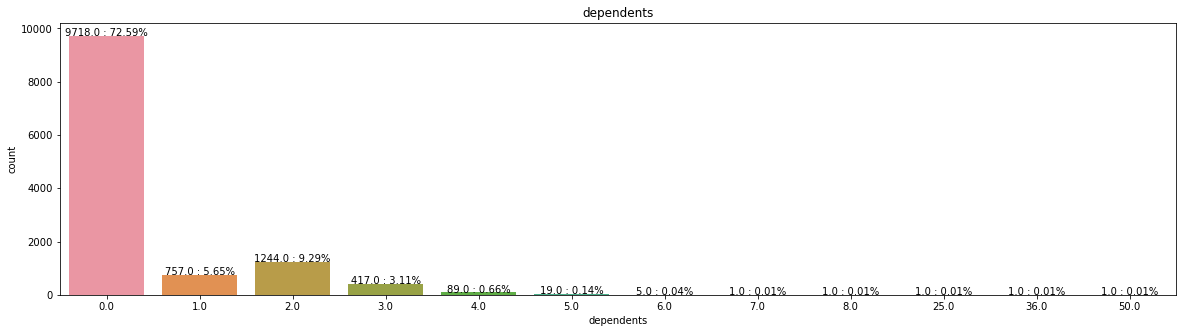

In [88]:
for i in ["customer_nw_category", "occupation", "gender", "dependents"]:
    uni_cat(outlier_df[['customer_id', i]])

#### CONTINOUS - CATEGORICAL

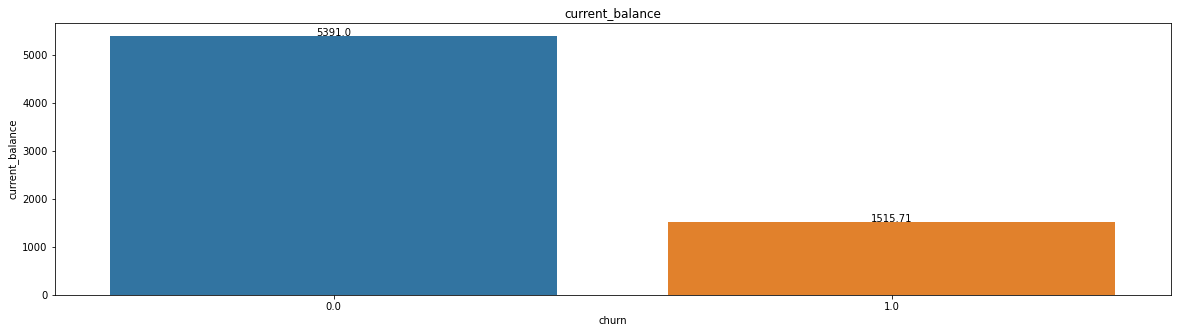

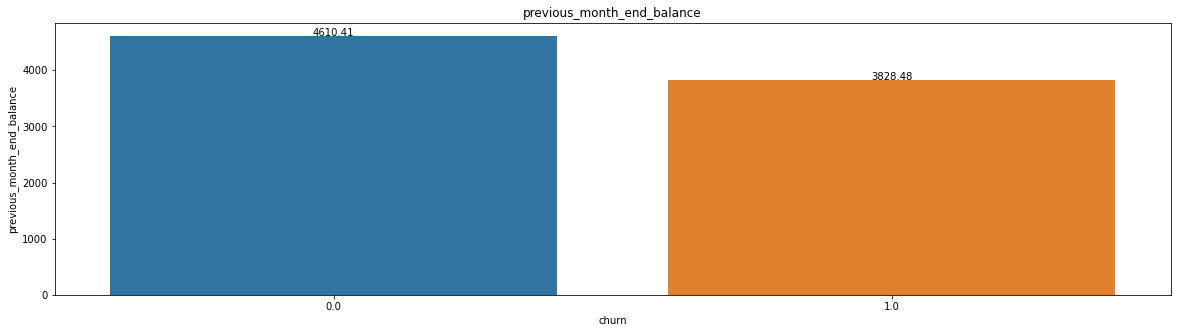

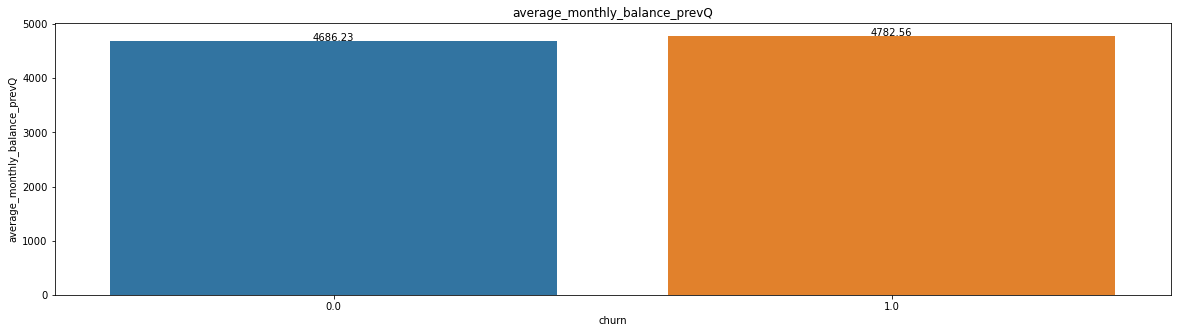

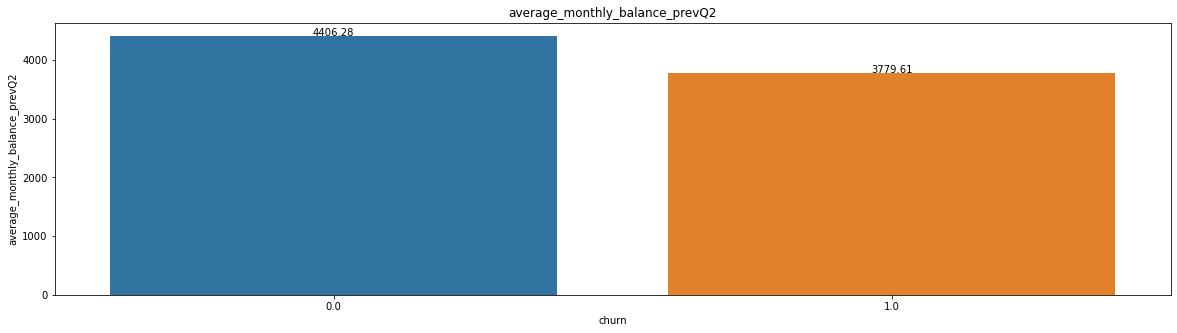

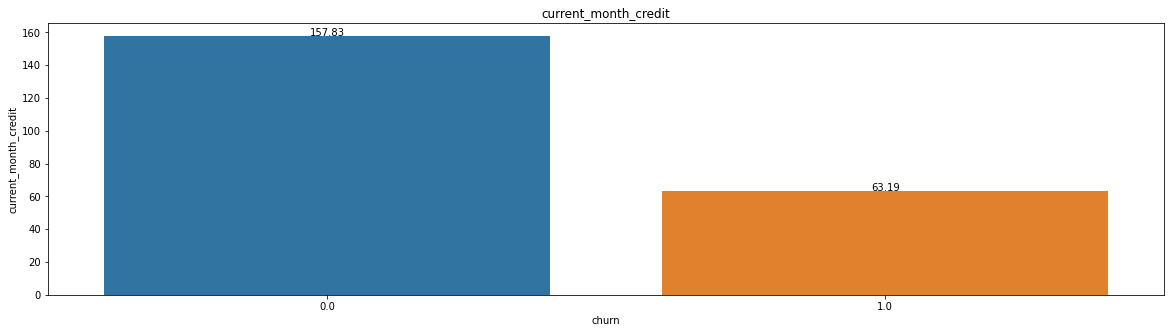

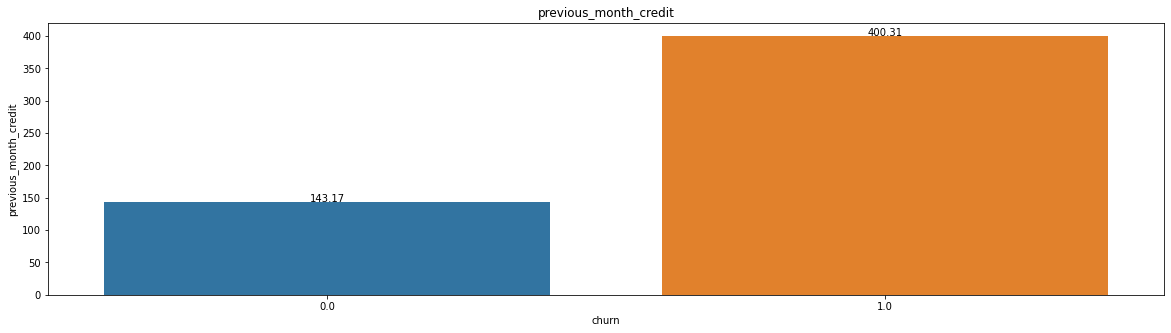

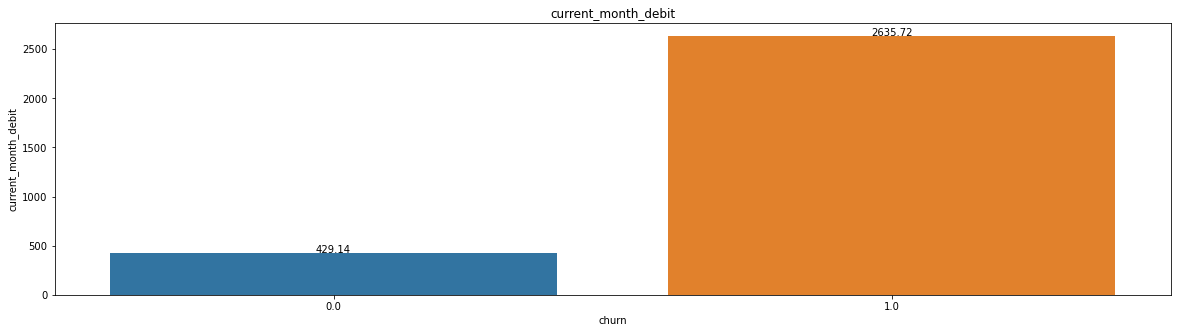

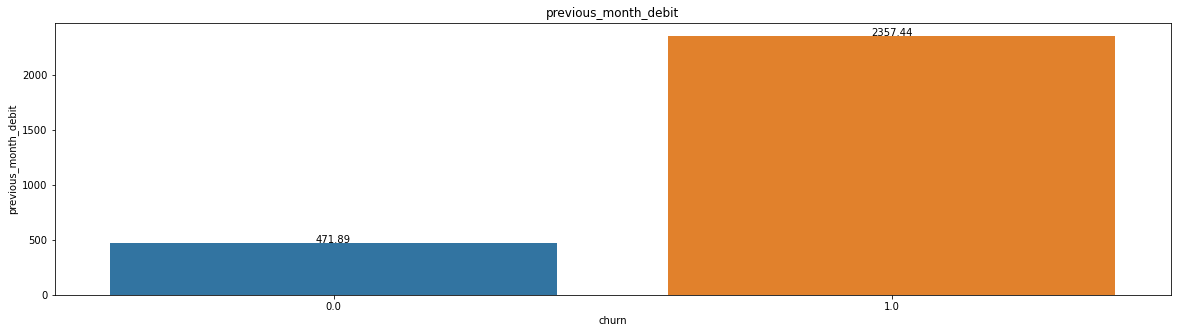

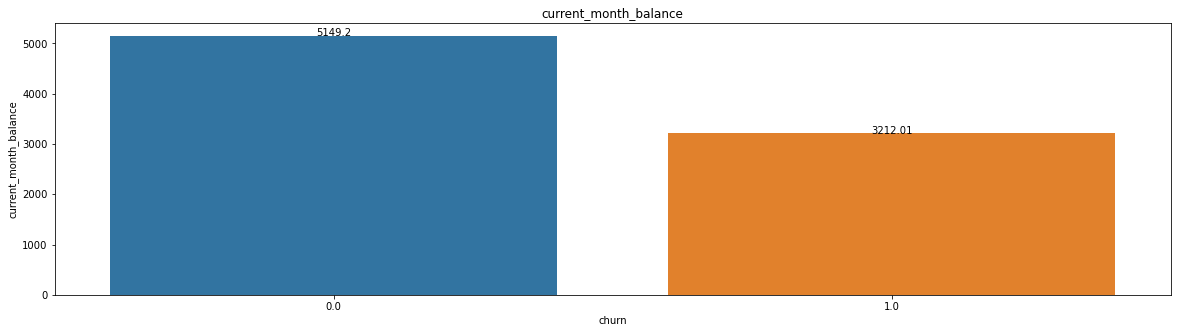

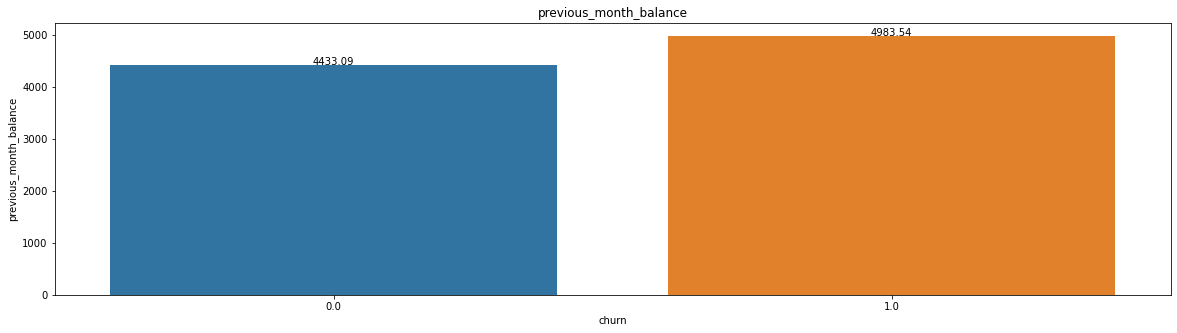

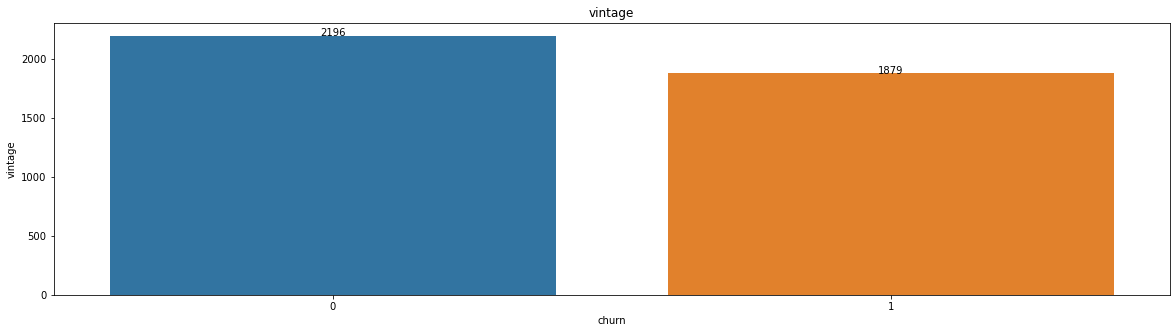

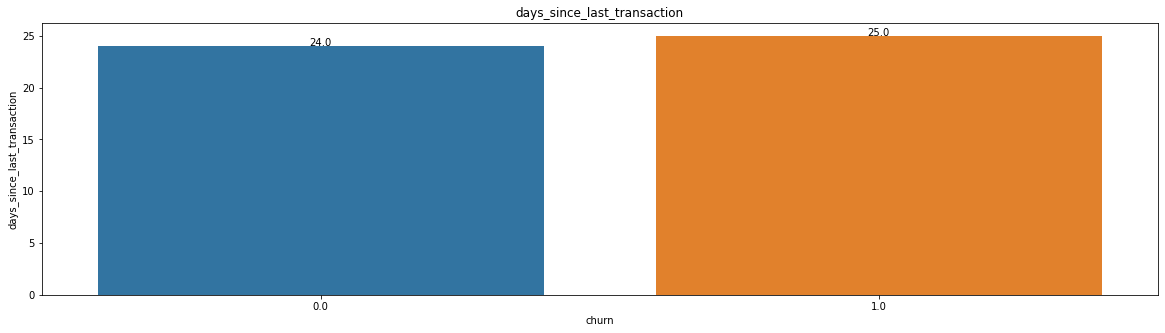

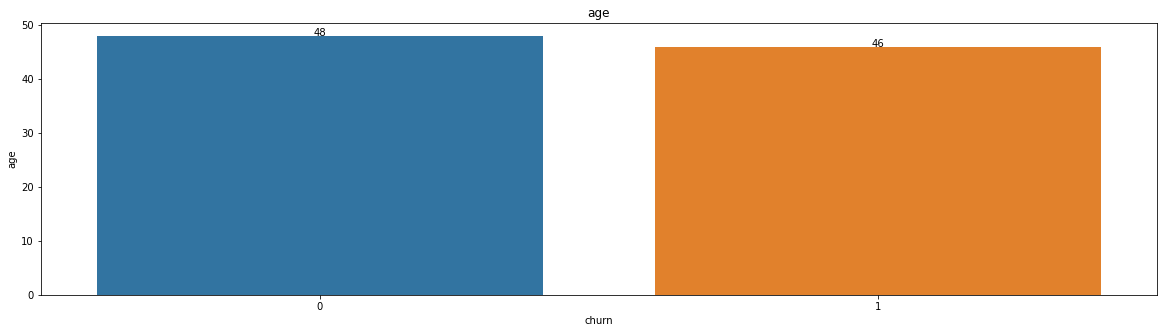

In [89]:
for i in cont_cols + time_based_cols:
    cont_cat(outlier_df[[i, "churn"]])

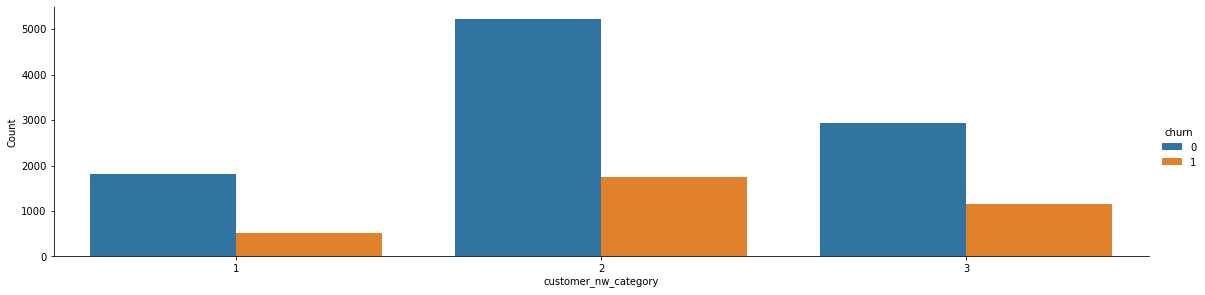

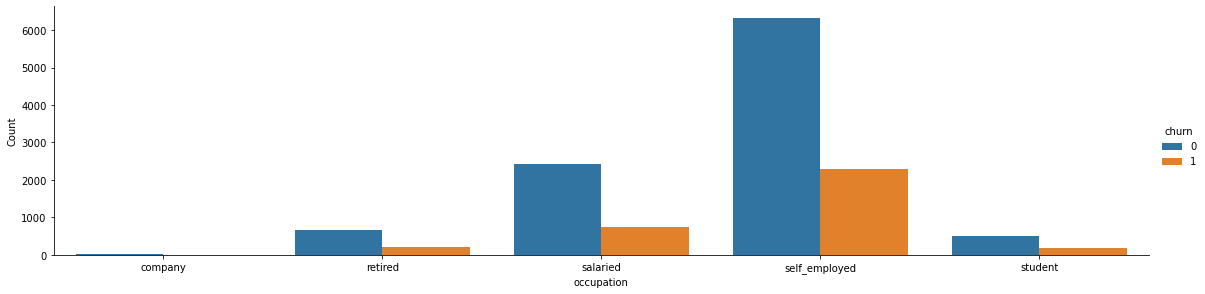

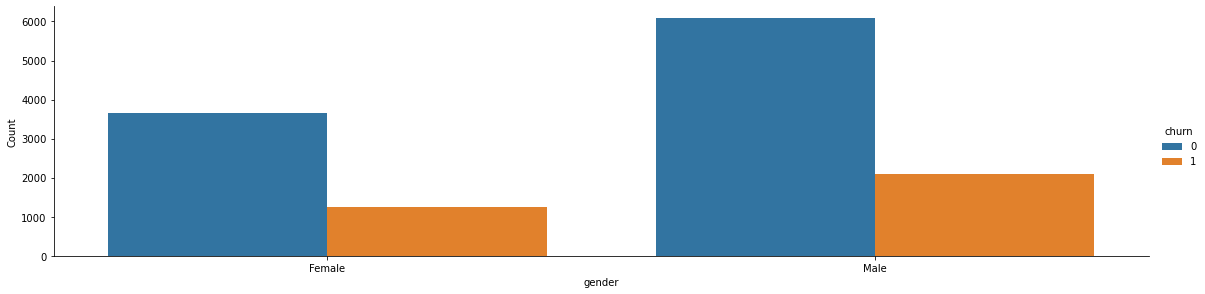

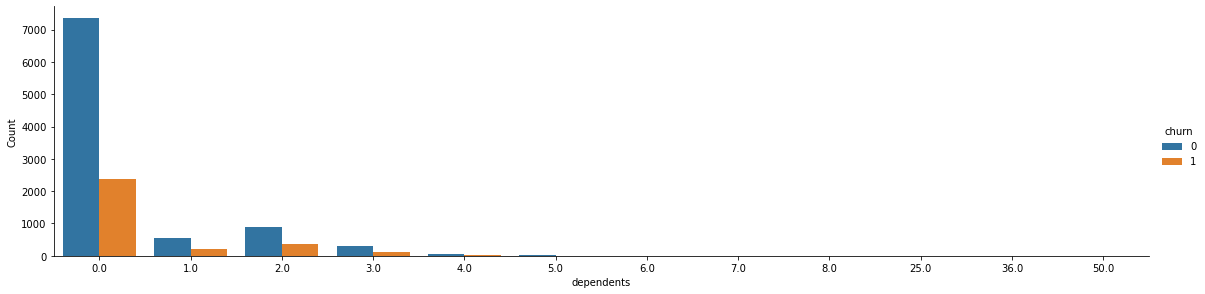

In [90]:
for i in ["customer_nw_category", "occupation", "gender", "dependents"]:
    cat_cat(outlier_df[[i, "churn", "customer_id"]])

# 3. FEATURE ENGINEERING

In [6]:
df = pd.read_csv('churn_prediction.csv')

#### NORMALIZING

In [7]:
for i in cont_cols:
    df[i] = np.log(df[i]+40).fillna(np.log(df[i]+40).mode()[0])

#### GENDER

In [8]:
df["gender_filled_new_cat"] = df.gender.fillna("T")

#### DEPENDENTS

In [9]:
df["dependents_filled_mode"] = df.dependents.fillna(df.dependents.mode()[0])

#### OCCUPATION

In [10]:
df["occupation_filled_mode"] = df.occupation.fillna(df.occupation.mode()[0])

#### DAYS SINCE LAST TRANSACTION

In [11]:
df["days_since_last_transaction_filled_999"] = df.days_since_last_transaction.fillna(999)

#### ONE HOT

In [12]:
for i in ['gender_filled_new_cat', 'occupation_filled_mode']:
    df = pd.concat([df, pd.get_dummies(df[i], prefix=i, drop_first= True)], axis=1)

#### CHANGE DTYPES

In [13]:
for i in ['vintage', 'age']:
    df[i] = df[i].astype('float64')

In [14]:
df['dependents_filled_mode_cat'] = df['dependents_filled_mode'].astype('int64').astype('O')

In [15]:
df['dependents_filled_mode'] = df.dependents_filled_mode.astype('int64')

In [16]:
df['customer_nw_category_cat'] = df.customer_nw_category.astype('O')

#### DROP

In [17]:
df = df.drop(['gender', 'dependents', 'city', 'occupation', 'days_since_last_transaction', 'branch_code'], axis=1)

#### DEPENDED FEATURE ENCODED

In [18]:
encoding = {}
for i in list(df.select_dtypes('O')):
    encoding[i + "_churn_mean"] = df.groupby([i])['churn'].mean().to_dict()
    encoding[i + "_churn_sum"] = df.groupby([i])['churn'].sum().to_dict()
    df[i + "_churn_mean"] = df.groupby([i])['churn'].transform('mean')
    df[i + "_churn_sum"] = df.groupby([i])['churn'].transform('sum')

# 4. FEATURE SELECTION

### HIGHLY CORRELATED FEATURES

In [18]:
cont = list(df.select_dtypes(['int64', 'float64']).columns)

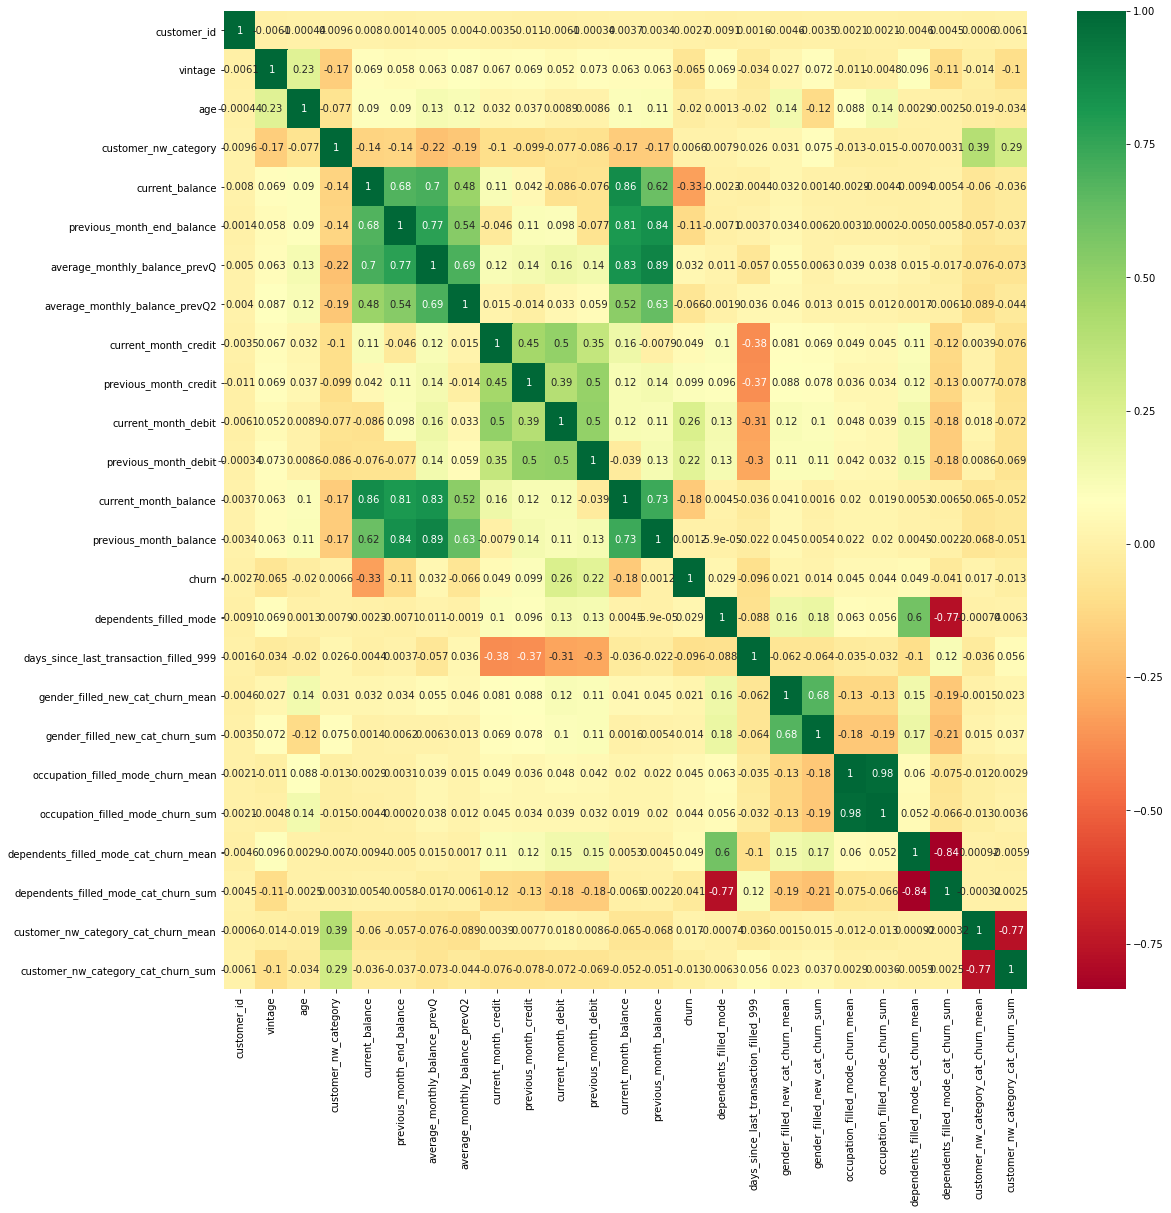

In [19]:
plt.figure(figsize = (18,18))
corr = df[cont].dropna().corr()
sns.heatmap(corr, annot = True, cmap = "RdYlGn")
plt.show()

In [20]:
hc = []
for i in corr:
    for j in corr:
        if abs(corr[i][j]) > 0.7 and abs(corr[i][j]) < 1:
            hc.append(" ".join(sorted([i, j])))
hc = list(set(hc))
hc

['current_month_balance previous_month_balance',
 'current_balance current_month_balance',
 'average_monthly_balance_prevQ previous_month_balance',
 'customer_nw_category_cat_churn_mean customer_nw_category_cat_churn_sum',
 'occupation_filled_mode_churn_mean occupation_filled_mode_churn_sum',
 'average_monthly_balance_prevQ current_month_balance',
 'previous_month_balance previous_month_end_balance',
 'current_month_balance previous_month_end_balance',
 'dependents_filled_mode_cat_churn_mean dependents_filled_mode_cat_churn_sum',
 'dependents_filled_mode dependents_filled_mode_cat_churn_sum',
 'average_monthly_balance_prevQ previous_month_end_balance']

### FEATURE IMPORTANCE

In [21]:
X = df.select_dtypes(["float64", "int64", "uint8", 'int32']).drop(['customer_id', 'churn'], axis=1)

In [22]:
y = df['churn']

In [23]:
selection = ExtraTreesRegressor()

In [24]:
selection.fit(X, y)

ExtraTreesRegressor()

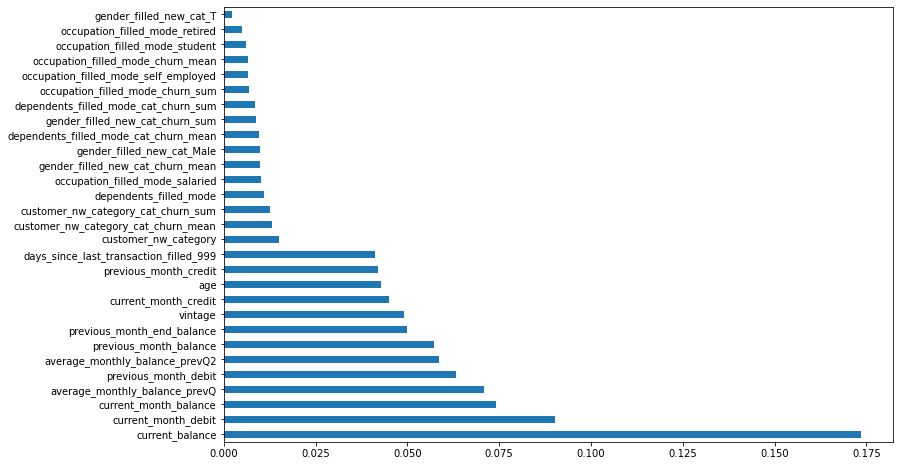

In [25]:
plt.figure(figsize = (12,8))
feat_importances = pd.Series(selection.feature_importances_, index=X.columns)
feat_importances.nlargest(30).plot(kind='barh')
plt.show()

In [26]:
best_cols = list(feat_importances.sort_values().index)[-20:]

In [19]:
best_cols = ['gender_filled_new_cat_Male',
 'gender_filled_new_cat_churn_mean',
 'occupation_filled_mode_salaried',
 'dependents_filled_mode',
 'customer_nw_category_cat_churn_sum',
 'customer_nw_category_cat_churn_mean',
 'customer_nw_category',
 'days_since_last_transaction_filled_999',
 'previous_month_credit',
 'age',
 'current_month_credit',
 'vintage',
 'previous_month_end_balance',
 'previous_month_balance',
 'average_monthly_balance_prevQ2',
 'previous_month_debit',
 'average_monthly_balance_prevQ',
 'current_month_balance',
 'current_month_debit',
 'current_balance']


# 5. MODEL SELECTION

In [29]:
def cv_score(X, y, ml_model, thres):
    i = 1
    cv_scores = []
    
    kf = StratifiedKFold(n_splits=10, random_state=11, shuffle=True)
    for train_index, test_index in kf.split(X, y):
        print('\n{} of kfold {}'.format(i, kf.n_splits))
        xtr,xvl = X.loc[train_index], X.loc[test_index]
        ytr,yvl = y[train_index], y[test_index]

        model = ml_model
        model.fit(xtr, ytr)
        ptr = model.predict_proba(xtr)
        pvl = model.predict_proba(xvl)
        pred_tr = []
        pred_vl = []
        
        for j in ptr[:,1]:
            if j>thres:
                pred_tr.append(1)
            else:
                pred_tr.append(0)
        
        for j in pvl[:,1]:
            if j>thres:
                pred_vl.append(1)
            else:
                pred_vl.append(0)
        
        recall_tr = recall_score(ytr, pred_tr)
        recall_vl = recall_score(yvl, pred_vl)
        roc_tr = roc_auc_score(ytr, pred_tr)
        roc_vl = roc_auc_score(yvl, pred_vl)
        msg = "Train RECALL: {:.5f} ".format(recall_tr)
        msg += "Valid RECALL: {:.5f} ".format(recall_vl)
        msg += "Train ROC: {:.5f} ".format(roc_tr)
        msg += "Valid ROC: {:.5f}".format(roc_vl)
        
        print("{}".format(msg))
        i+=1

In [20]:
X = df.select_dtypes(["float64", "int64", "uint8", 'int32']).drop(['customer_id', 'churn'], axis=1)[best_cols]
stdscaler = StandardScaler().fit(X)
Xstdscaler = pd.DataFrame(stdscaler.transform(X), columns=X.columns)

In [21]:
y = df['churn']

In [33]:
joblib.dump(stdscaler, 'std_scaler.bin', compress=True)

['std_scaler.bin']

### LOGISTIC REGRESSION

In [34]:
cv_score(Xstdscaler, y, LogisticRegression(), 0.20)


1 of kfold 10
Train RECALL: 0.68673 Valid RECALL: 0.67871 Train ROC: 0.77304 Valid ROC: 0.77212

2 of kfold 10
Train RECALL: 0.68547 Valid RECALL: 0.67490 Train ROC: 0.77293 Valid ROC: 0.77152

3 of kfold 10
Train RECALL: 0.68716 Valid RECALL: 0.64449 Train ROC: 0.77541 Valid ROC: 0.74958

4 of kfold 10
Train RECALL: 0.68378 Valid RECALL: 0.70913 Train ROC: 0.77267 Valid ROC: 0.78255

5 of kfold 10
Train RECALL: 0.68716 Valid RECALL: 0.66730 Train ROC: 0.77332 Valid ROC: 0.76207

6 of kfold 10
Train RECALL: 0.68209 Valid RECALL: 0.69962 Train ROC: 0.77209 Valid ROC: 0.77909

7 of kfold 10
Train RECALL: 0.68230 Valid RECALL: 0.70152 Train ROC: 0.77229 Valid ROC: 0.78199

8 of kfold 10
Train RECALL: 0.68335 Valid RECALL: 0.69772 Train ROC: 0.77255 Valid ROC: 0.77857

9 of kfold 10
Train RECALL: 0.68272 Valid RECALL: 0.71293 Train ROC: 0.77120 Valid ROC: 0.78575

10 of kfold 10
Train RECALL: 0.68568 Valid RECALL: 0.64639 Train ROC: 0.77410 Valid ROC: 0.75464


### DECISION TREE

In [35]:
cv_score(Xstdscaler, y, DecisionTreeClassifier(criterion="gini", random_state=42,max_depth=10, min_samples_leaf=7), 0.2)


1 of kfold 10
Train RECALL: 0.70765 Valid RECALL: 0.58745 Train ROC: 0.80586 Valid ROC: 0.73860

2 of kfold 10
Train RECALL: 0.72940 Valid RECALL: 0.61977 Train ROC: 0.80622 Valid ROC: 0.74395

3 of kfold 10
Train RECALL: 0.71398 Valid RECALL: 0.57034 Train ROC: 0.80625 Valid ROC: 0.71813

4 of kfold 10
Train RECALL: 0.72539 Valid RECALL: 0.58175 Train ROC: 0.81044 Valid ROC: 0.72081

5 of kfold 10
Train RECALL: 0.71779 Valid RECALL: 0.60076 Train ROC: 0.80474 Valid ROC: 0.73355

6 of kfold 10
Train RECALL: 0.72412 Valid RECALL: 0.62548 Train ROC: 0.80435 Valid ROC: 0.74159

7 of kfold 10
Train RECALL: 0.71018 Valid RECALL: 0.62738 Train ROC: 0.80358 Valid ROC: 0.74946

8 of kfold 10
Train RECALL: 0.73447 Valid RECALL: 0.62548 Train ROC: 0.81116 Valid ROC: 0.74397

9 of kfold 10
Train RECALL: 0.70638 Valid RECALL: 0.57034 Train ROC: 0.80797 Valid ROC: 0.72310

10 of kfold 10
Train RECALL: 0.70765 Valid RECALL: 0.57605 Train ROC: 0.80440 Valid ROC: 0.72942


### RANDOM FOREST CLASSIFIER

In [36]:
cv_score(Xstdscaler, y, RandomForestClassifier(), 0.2)


1 of kfold 10
Train RECALL: 1.00000 Valid RECALL: 0.73764 Train ROC: 0.98515 Valid ROC: 0.76636

2 of kfold 10
Train RECALL: 1.00000 Valid RECALL: 0.74144 Train ROC: 0.98417 Valid ROC: 0.77301

3 of kfold 10
Train RECALL: 1.00000 Valid RECALL: 0.71483 Train ROC: 0.98520 Valid ROC: 0.75447

4 of kfold 10
Train RECALL: 1.00000 Valid RECALL: 0.72433 Train ROC: 0.98455 Valid ROC: 0.75512

5 of kfold 10
Train RECALL: 1.00000 Valid RECALL: 0.74144 Train ROC: 0.98510 Valid ROC: 0.76605

6 of kfold 10
Train RECALL: 1.00000 Valid RECALL: 0.77186 Train ROC: 0.98498 Valid ROC: 0.78732

7 of kfold 10
Train RECALL: 1.00000 Valid RECALL: 0.75285 Train ROC: 0.98484 Valid ROC: 0.78149

8 of kfold 10
Train RECALL: 1.00000 Valid RECALL: 0.74715 Train ROC: 0.98472 Valid ROC: 0.77085

9 of kfold 10
Train RECALL: 1.00000 Valid RECALL: 0.76806 Train ROC: 0.98436 Valid ROC: 0.77936

10 of kfold 10
Train RECALL: 1.00000 Valid RECALL: 0.73004 Train ROC: 0.98549 Valid ROC: 0.76467


### XGBOOST

In [37]:
xtrain, xtest, ytrain, ytest = train_test_split(Xstdscaler,y,test_size=0.9, random_state=0, stratify=y)

In [38]:
parameters = {'nthread': -1,
              'objective':'binary:logistic',
              'max_depth': 2,
              'min_child_weight': 5,
              'silent': 1,
              'subsample': 0.7,
              'colsample_bytree': 0.7,
              'n_estimators': 200,
             }

In [39]:
xgb_model = xgb.XGBClassifier(**parameters, verbosity=1)

In [40]:
xgb_model.fit(xtrain, ytrain)

[17:31:35] WARNING: ..\src\learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:31:35] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=2,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=4, nthread=-1, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              silent=1, subsample=0.7, tree_method='exact',
              validate_parameters=1, verbosity=1)

In [41]:
pred_tr = xgb_model.predict(xtrain)
pred_vl = xgb_model.predict(xtest)

recall_tr = recall_score(ytrain, pred_tr)
recall_vl = recall_score(ytest, pred_vl)
roc_tr = roc_auc_score(ytrain, pred_tr)
roc_vl = roc_auc_score(ytest, pred_vl)
msg = "Train RECALL: {:.5f} ".format(recall_tr)
msg += "Valid RECALL: {:.5f} ".format(recall_vl)
msg += "Train ROC: {:.5f} ".format(roc_tr)
msg += "Valid ROC: {:.5f}".format(roc_vl)

print("{}".format(msg))

Train RECALL: 0.62738 Valid RECALL: 0.43747 Train ROC: 0.80461 Valid ROC: 0.69360


### CATBOOST

In [42]:
cb_model = CatBoostClassifier(iterations=1000,
                             learning_rate=0.04,
                             eval_metric='AUC',
                             task_type="GPU",
                             devices='0:1',
                             metric_period = 100,
                             max_depth=5
                            )

In [43]:
XN = df.select_dtypes(['int64', 'float64', 'O','int32', 'uint8']).drop(['customer_id','churn'], axis=1)

In [44]:
yn = df['churn']

In [45]:
cat_features = [i for i, col in enumerate(XN.columns) if XN[col].dtype=='O']

In [46]:
xtrain, xtest, ytrain, ytest = train_test_split(XN,yn,test_size=0.9, random_state=0)

In [47]:
cb_model.fit(
    xtrain, ytrain,
    eval_set=(xtest, ytest),
    cat_features=cat_features,
    use_best_model=True,
    verbose=True
)

0:	learn: 0.5194632	test: 0.5083164	best: 0.5083164 (0)	total: 92.6ms	remaining: 1m 32s
100:	learn: 0.8382640	test: 0.7961153	best: 0.7961153 (100)	total: 8.34s	remaining: 1m 14s
200:	learn: 0.8659411	test: 0.8150532	best: 0.8150532 (200)	total: 16.9s	remaining: 1m 7s
300:	learn: 0.8763385	test: 0.8173882	best: 0.8173882 (300)	total: 25.4s	remaining: 59.1s
400:	learn: 0.8882139	test: 0.8194428	best: 0.8194428 (400)	total: 34.2s	remaining: 51.2s
500:	learn: 0.8937474	test: 0.8198126	best: 0.8198126 (500)	total: 42.5s	remaining: 42.4s
600:	learn: 0.8969827	test: 0.8196819	best: 0.8198126 (500)	total: 50.8s	remaining: 33.8s
700:	learn: 0.9006473	test: 0.8199586	best: 0.8199586 (700)	total: 59.2s	remaining: 25.2s
800:	learn: 0.9044700	test: 0.8203181	best: 0.8203181 (800)	total: 1m 7s	remaining: 16.7s
900:	learn: 0.9068071	test: 0.8204010	best: 0.8204010 (900)	total: 1m 15s	remaining: 8.28s
999:	learn: 0.9087334	test: 0.8201096	best: 0.8204010 (900)	total: 1m 23s	remaining: 0us
bestTest = 

In [48]:
pred_tr = cb_model.predict(xtrain)
pred_vl = cb_model.predict(xtest)

recall_tr = recall_score(ytrain, pred_tr)
recall_vl = recall_score(ytest, pred_vl)
roc_tr = roc_auc_score(ytrain, pred_tr)
roc_vl = roc_auc_score(ytest, pred_vl)
msg = "Train RECALL: {:.5f} ".format(recall_tr)
msg += "Valid RECALL: {:.5f} ".format(recall_vl)
msg += "Train ROC: {:.5f} ".format(roc_tr)
msg += "Valid ROC: {:.5f}".format(roc_vl)

print("{}".format(msg))

Train RECALL: 0.45455 Valid RECALL: 0.42194 Train ROC: 0.71183 Valid ROC: 0.69042


### NN

In [22]:
xtrain, xtest, ytrain, ytest = train_test_split(Xstdscaler[best_cols], y, test_size=0.9, random_state=0, stratify=y)

In [48]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.f1 = nn.Linear(Xstdscaler.shape[1],128)
        self.f2 = nn.Linear(128,64)
        self.f3 = nn.Linear(64,32)
        self.f4 = nn.Linear(32,1)
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()
    def forward(self, input1):
        x = self.f1(input1)
        x = self.relu(x)
        x = self.f2(x)
        x = self.relu(x)
        x = self.f3(x)
        x = self.relu(x)
        x = self.f4(x)
        x = self.sig(x)
        return x

In [43]:
model = Classifier()#.to('cuda')

In [44]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.002)

In [45]:
def train():
    model.train()
    X = torch.tensor(xtrain.values, dtype=torch.float)#.cuda()
    y = torch.tensor(ytrain.values, dtype=torch.float)#.cuda()
    model.zero_grad()
    preds = model(X)
    loss = nn.functional.binary_cross_entropy(preds.squeeze(), y)
    loss.backward()
    optimizer.step()
    roc_train = roc_auc_score(y.detach().cpu().numpy(), preds.detach().cpu().squeeze().numpy())
    return roc_train

In [46]:
def test():
    model.eval()
    X = torch.tensor(xtest.values, dtype=torch.float)#.cuda()
    y = torch.tensor(ytest.values, dtype=torch.float)#.cuda()
    preds = model(X)
    roc_test = roc_auc_score(y.detach().cpu().numpy(), preds.detach().cpu().squeeze().numpy())
    return roc_test

In [55]:
best_roc = 0
epochs = 1000
roc_test = 0
for epoch in range(epochs):
    roc_train = train()
    roc_test = test()
    if roc_test > best_roc:
        torch.save(model.state_dict(), 'saved_weights.pt')
        print('SAVING BEST MODEL.....EPOCH {:} / {:}.....TEST ROC {}'.format(epoch + 1, epochs, roc_test))
        best_roc = roc_test

SAVING BEST MODEL.....EPOCH 1 / 1000.....TEST ROC 0.38288359261485666
SAVING BEST MODEL.....EPOCH 8 / 1000.....TEST ROC 0.3895185218344419
SAVING BEST MODEL.....EPOCH 9 / 1000.....TEST ROC 0.3999002533027105
SAVING BEST MODEL.....EPOCH 10 / 1000.....TEST ROC 0.4127060837923011
SAVING BEST MODEL.....EPOCH 11 / 1000.....TEST ROC 0.4288359972040676
SAVING BEST MODEL.....EPOCH 12 / 1000.....TEST ROC 0.4486266240496073
SAVING BEST MODEL.....EPOCH 13 / 1000.....TEST ROC 0.47181778953644815
SAVING BEST MODEL.....EPOCH 14 / 1000.....TEST ROC 0.4973985362972816
SAVING BEST MODEL.....EPOCH 15 / 1000.....TEST ROC 0.5243251909819606
SAVING BEST MODEL.....EPOCH 16 / 1000.....TEST ROC 0.5513956975285069
SAVING BEST MODEL.....EPOCH 17 / 1000.....TEST ROC 0.5774494049304804
SAVING BEST MODEL.....EPOCH 18 / 1000.....TEST ROC 0.6016593185127799
SAVING BEST MODEL.....EPOCH 19 / 1000.....TEST ROC 0.623766801326992
SAVING BEST MODEL.....EPOCH 20 / 1000.....TEST ROC 0.6436066696347564
SAVING BEST MODEL.....

In [56]:
encodings_df = pd.DataFrame()

In [57]:
values = []
for i in encoding:
    values.extend([i] * len(encoding[i]))
encodings_df["COLUMNS"] = values

In [58]:
values = []
for i in encoding:
    values.extend(encoding[i].keys())
encodings_df["COLUMNS_VALUES"] = values

In [59]:
values = []
for i in encoding:
    for j in encoding[i]:
        values.append(encoding[i][j])
encodings_df["VALUES"] = values

In [60]:
encodings_df.to_csv('encoding.csv')

In [63]:
xtrain.dtypes

gender_filled_new_cat_Male                float64
gender_filled_new_cat_churn_mean          float64
occupation_filled_mode_salaried           float64
dependents_filled_mode                    float64
customer_nw_category_cat_churn_sum        float64
customer_nw_category_cat_churn_mean       float64
customer_nw_category                      float64
days_since_last_transaction_filled_999    float64
previous_month_credit                     float64
age                                       float64
current_month_credit                      float64
vintage                                   float64
previous_month_end_balance                float64
previous_month_balance                    float64
average_monthly_balance_prevQ2            float64
previous_month_debit                      float64
average_monthly_balance_prevQ             float64
current_month_balance                     float64
current_month_debit                       float64
current_balance                           float64


In [ ]:
NULL
1. Mean/Median/Mode replacement(MCAR)
2. Random Sample Imputation(MCAR)
3. Capturing NAN values with a new feature(MCNAR)
4. End of Distribution imputation
5. Arbitrary imputation
6. Frequent categories imputation
7. New category imputation 

In [ ]:
XN

In [ ]:
ORDINAL
1. Count or frequency encoding
2. Target Guided Ordinal Encoding
Ordering the labels according to the target
Replace the labels by the joint probability of being 1 or 0

In [ ]:
NOMINAL
1. one hot
2. top n
3. target guided